In [1]:
#### IMPORTS
import os

import importlib, pkg_resources
importlib.reload(pkg_resources)

import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

from cirq.contrib.svg import SVGCircuit
%matplotlib inline

# test

In [2]:

print("before", tf.keras.backend.floatx())
tf.keras.backend.set_floatx('float64')
tf.keras.backend.floatx()

before float32


'float64'

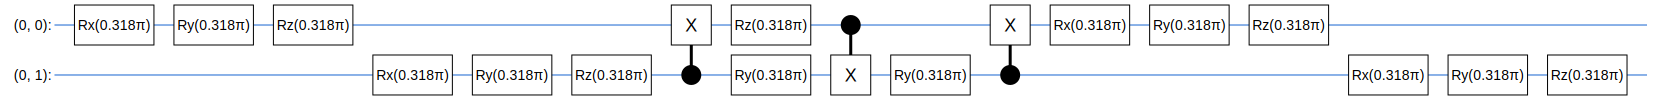

In [3]:
def one_qubit_unitary(bit, symbols):
    """Make a Cirq circuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis, that depends on the values in `symbols`.
    """
    return cirq.Circuit(
        cirq.rx(symbols[0])(bit),
        cirq.ry(symbols[1])(bit),
        cirq.rz(symbols[2])(bit))


# https://arxiv.org/pdf/quant-ph/0308006.pdf
def two_qubit_unitary(bits, symbols, full=False):
    """Make a Cirq circuit that creates a non arbitrary two qubit unitary."""
    circuit = cirq.Circuit()
    if full:
        circuit += one_qubit_unitary(bits[0], symbols[0:3])
        circuit += one_qubit_unitary(bits[1], symbols[3:6])
    
    
    #circuit += cirq.rz(-np.pi/2.)(bits[1])
        
    circuit += cirq.CNOT(bits[1],bits[0])
    
    circuit += cirq.rz(symbols[0+6*full])(bits[0])
    circuit += cirq.ry(symbols[1+6*full])(bits[1])  
    
    circuit += cirq.CNOT(bits[0],bits[1])
    
    circuit += cirq.ry(symbols[2+6*full])(bits[1]) 
    
    circuit += cirq.CNOT(bits[1],bits[0])
        
    #circuit += cirq.rz(np.pi/2.)(bits[0]) 
    
    
    #circuit += [cirq.ZZ(*bits)**symbols[6]]   They want to replicate this
    #circuit += [cirq.YY(*bits)**symbols[7]]
    #circuit += [cirq.XX(*bits)**symbols[8]]
    if full:   
        circuit += one_qubit_unitary(bits[0], symbols[9:12])
        circuit += one_qubit_unitary(bits[1], symbols[12:15])
        
    return circuit

bits = cirq.GridQubit.rect(1,2)
SVGCircuit(two_qubit_unitary(bits, np.ones(16), full=True))

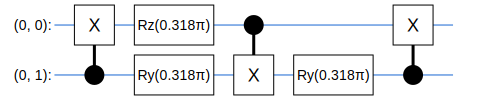

In [83]:
bits = cirq.GridQubit.rect(1,2)
SVGCircuit(two_qubit_unitary(bits, np.ones(16), full=False))

In [4]:
# Example circuit simple
# Count number of excitations (1), if number of excitations > half qbits, show 1, else 0

# to pass data as initial state we must construc it. So we need to give the cirucit. It's just X gate. X^{num} = X^{n0}X^{n1}...


def generate_data(qubits):
    test = []
    label = []
    
    n = len(qubits)
    for i in range(2**n):
        b = bin(i)[2:]
        b = '0'*(n-len(b)) + b
        count = 0
        for c in b:
            if c == '1':
                count+=1
            
        label.append(-1 if count > n/2 else +1)
        test.append(cirq.Circuit( (cirq.X(qubits[l]) for l in range(len(b)) if b[l]=='1')))
        
    return tfq.convert_to_tensor(test), np.array(label)

qubits = cirq.GridQubit.rect(1,5)

test, label = generate_data(qubits)



In [8]:
bits = cirq.GridQubit.rect(1,5)
cirq.Circuit(cirq.X(bits[0]), cirq.X(bits[0])) + cirq.Circuit(cirq.X(bits[1]))

(0, 0): ───X───X───────

(0, 1): ───────────X───

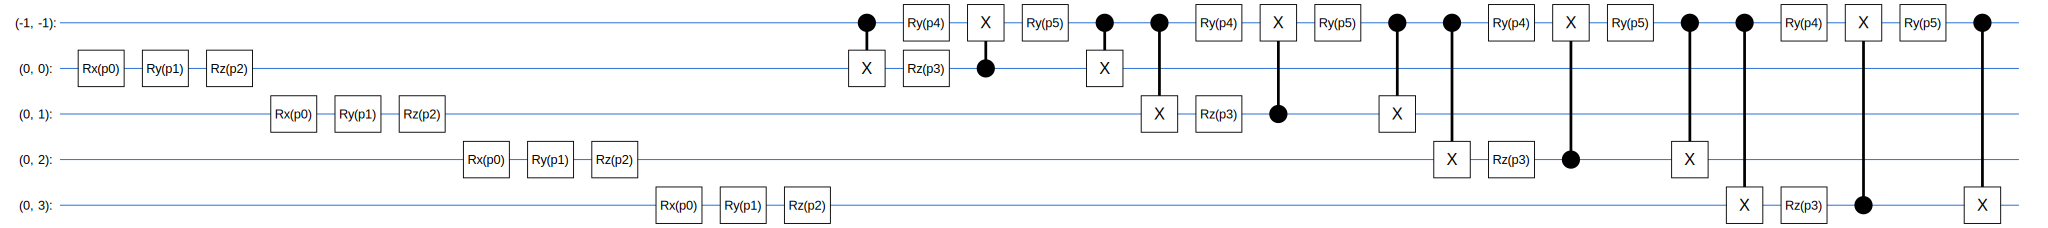

In [721]:
def quantum_circuit(op_bits, readout_bit, parameters, full=False):
    """Quantum Convolution Layer following the above diagram.
    Return a Cirq circuit with the cascade of `two_qubit_unitary` applied
    to all pairs of qubits in `bits` as in the diagram above.
    """
    circuit = cirq.Circuit()
    
    #obs = np.prod([Z(4n)])
    #obs = SymbolicHamiltonian(obs, backend=backend)
    
    for bit in op_bits:
        circuit += one_qubit_unitary(bit, parameters[0:3])
        
    """for bit, bitn in zip(op_bits[:-1], op_bits[1:]):
        circuit += two_qubit_unitary([bit, bitn], parameters[6+12*full:9+12*full], full=False)
        
    circuit += two_qubit_unitary([op_bits[-1], op_bits[0]], parameters[3:6], full=False)"""
        
    for bit in op_bits:
        circuit += two_qubit_unitary([bit, readout_bit], parameters[3:6+12*full], full=full)
        
    """for bit, bitn in zip(op_bits[:-1], op_bits[1:]):
        circuit += two_qubit_unitary([bit, bitn], parameters[9+12*full:12+12*full], full=False)
        
    circuit += two_qubit_unitary([op_bits[-1], op_bits[0]], parameters[9+12*full:12+12*full], full=False)"""
        
    
    
    
    """for bit in op_bits:
        circuit += one_qubit_unitary(bit, parameters[6:9])
        
    for bit in op_bits:
        circuit += two_qubit_unitary([bit, readout_bit], parameters[9:12], full=False)
        
        
    
    
    for bit in op_bits:
        circuit += one_qubit_unitary(bit, parameters[12:15])
    
    for bit in op_bits:
        circuit += two_qubit_unitary([bit, readout_bit], parameters[15:18], full=False)"""
        
    
    
    
        
    #for bit in op_bits:
    #    circuit += two_qubit_unitary([bit, readout_bit], parameters[3:], full=full)
        
    
    return circuit

param = sympy.symbols('p:100')


n = 4


qubits = cirq.GridQubit.rect(1,n)
readoutqubit = cirq.GridQubit(-1,-1)

excitation_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
input_layer = tfq.layers.AddCircuit()(
    excitation_input, prepend=cirq.Circuit())

readout_operators = cirq.Z(readoutqubit)

quantum_model_circuit = quantum_circuit(qubits, readoutqubit, param, full=False)



# CUSTOMIZE
quantum_modelPQC = tfq.layers.PQC(quantum_model_circuit,
                                  readout_operators, 
                                  initializer=tf.keras.initializers.Constant(value=1.0),
                                  differentiator=tfq.differentiators.ParameterShift())
                                  #backend=cirq.Simulator())
                                     
    
                                    ## Differentiators
                                  #differentiator=tfq.differentiators.ParameterShift(),
                                    
                                    ## Sampling
                                    #repetitions=None)
                    
                                    ## Initializer (parameters)
                                    #tf.keras.initializers.RandomUniform(0, 2 * np.pi)
                                    #tf.keras.initializers.Constant(value=1.0)
                                
                                  #initializer=tf.keras.initializers.RandomUniform(0, 2 * np.pi))
                                  #repetitions=10) # None: state vector expectation / Number: Sampling

qm = quantum_modelPQC
                                
quantum_model = quantum_modelPQC(input_layer)

qcnn_model = tf.keras.Model(inputs=[excitation_input], outputs=[quantum_model])



SVGCircuit(
    quantum_model_circuit)#sympy.symbols('x0:15')))

In [90]:
# Breaks with float 64???

@tf.function
def custom_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true)
    y_pred = tf.map_fn(lambda x: 1.0 if x >= 0 else -1.0, y_pred)
    return tf.keras.backend.mean(tf.keras.backend.equal(y_true, y_pred))

In [181]:
inputs, labels = generate_data(qubits)


ninp = len(inputs)
split = int(ninp*1)

train_excitations = inputs[:split]
train_labels = labels[:split]

test_excitations = inputs[split:]
test_labels = labels[split:]

#tf.keras.optimizers.Adam(learning_rate=0.02)
#tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False)
#tf.keras.optimizers.Adam(learning_rate=0.02)  # Adams                   # Default parameters, but made explicit. Basic gradient descent
qcnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
                   loss=tf.losses.mse)#,
                   #metrics=[custom_accuracy])
    
print(qcnn_model.get_weights())

history = qcnn_model.fit(x=train_excitations,
                         y=train_labels,
                         batch_size=1,
                         epochs=100,
                         verbose=1,
                         validation_data=(test_excitations, test_labels))

[array([1., 1., 1., 1., 1., 1.], dtype=float32)]
Epoch 1/100
16/16 [==============================] - 1s 32ms/step - loss: 1.0031
Epoch 2/100
16/16 [==============================] - 0s 30ms/step - loss: 0.9175
Epoch 3/100
16/16 [==============================] - 0s 28ms/step - loss: 0.8946
Epoch 4/100
16/16 [==============================] - 0s 28ms/step - loss: 0.9009
Epoch 5/100
16/16 [==============================] - 0s 27ms/step - loss: 0.8833
Epoch 6/100
16/16 [==============================] - 0s 28ms/step - loss: 0.8649
Epoch 7/100
16/16 [==============================] - 0s 31ms/step - loss: 0.8516
Epoch 8/100
16/16 [==============================] - 0s 30ms/step - loss: 0.8262
Epoch 9/100
16/16 [==============================] - 0s 27ms/step - loss: 0.8113
Epoch 10/100
16/16 [==============================] - 0s 27ms/step - loss: 0.7910
Epoch 11/100
16/16 [==============================] - 0s 28ms/step - loss: 0.7698
Epoch 12/100
16/16 [==============================] - 0s 2

KeyError: 'val_loss'

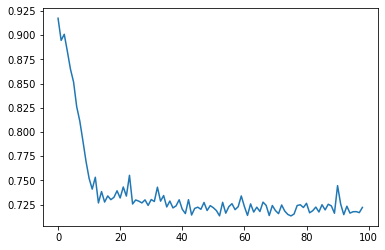

In [183]:
plt.plot(history.history['loss'][1:], label='Training')
plt.plot(history.history['val_loss'][1:], label='Validation')
plt.title('Training a Quantum CNN to Detect Excited Cluster States')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [567]:
print(*tuple("{:20} =? {:3}   --->   {:5}".format(x[0], train_labels[i], abs(train_labels[i]-x[0])<1)  for i,x in enumerate(qcnn_model.predict(train_excitations))), sep='\n')


qcnn_model.trainable_variables

 0.05134811997413635 =?   1   --->       1
-0.22285966575145721 =?   1   --->       0
-0.22692462801933289 =?   1   --->       0
-0.03146733343601227 =?   1   --->       0
0.014224156737327576 =?   1   --->       1
-0.08988440781831741 =?   1   --->       0
 -0.0807948037981987 =?   1   --->       0
 0.03189695626497269 =?  -1   --->       0
 0.46371498703956604 =?   1   --->       1
 -0.2625795304775238 =?   1   --->       0
 -0.2849717140197754 =?   1   --->       0
 0.23775608837604523 =?  -1   --->       0
 0.41558054089546204 =?   1   --->       1
 -0.1411268711090088 =?  -1   --->       1
-0.11158232390880585 =?  -1   --->       1
 0.15126290917396545 =?  -1   --->       0


[<tf.Variable 'parameters:0' shape=(24,) dtype=float32, numpy=
 array([0.9316327, 1.6815913, 1.0111773, 2.1699822, 3.8568354, 6.1286526,
        3.102644 , 1.5660274, 2.7262068, 1.72624  , 4.1483912, 4.511825 ,
        3.2235281, 3.1371534, 3.6869867, 5.4236717, 4.194628 , 5.3430223,
        1.7805375, 5.125231 , 3.3614523, 3.445503 , 4.930834 , 6.0574546],
       dtype=float32)>]

####  Manual Training

In [11]:
def generate_data_p(qubits):
    test = []
    label = []
    
    n = len(qubits)
    for i in range(2**n):
        b = bin(i)[2:]
        b = '0'*(n-len(b)) + b
        count = 0
        for c in b:
            if c == '1':
                count+=1
        #b = b[::-1]
            
        label.append(-1 if count %2 == 1 else +1)
        test.append(cirq.Circuit( (cirq.X(qubits[l]) for l in range(len(b)) if b[l]=='1')))
        """print(b)
        print(test[-1])"""
    return tfq.convert_to_tensor(test), np.array(label)

def quantum_circuit(op_bits, readout_bit, parameters, full=False, cnot=True, extra=False, depth=1, firstOne = True):
    """Quantum Convolution Layer following the above diagram.
    Return a Cirq circuit with the cascade of `two_qubit_unitary` applied
    to all pairs of qubits in `bits` as in the diagram above.
    """
    circuit = cirq.Circuit()
    
    #obs = np.prod([Z(4n)])
    #obs = SymbolicHamiltonian(obs, backend=backend)
    
    if cnot:
        for bit in op_bits:
            circuit += cirq.CNOT(bit, readout_bit)
    
    if firstOne:
        for bit in op_bits:
            circuit += one_qubit_unitary(bit, parameters[0:3])
    
    for dd in range(depth):
        
        """for bit in op_bits:
            circuit += one_qubit_unitary(bit, parameters[0:3])
            circuit += cirq.CNOT(bit, readout_bit)
        circuit += one_qubit_unitary(readout_bit, parameters[0:3])"""  # Really symmetric simple with CNOT
            
        for bit in op_bits:
            circuit += two_qubit_unitary([bit, readout_bit], parameters[3*(dd*(1+4*full)+1):3*(dd*(1+4*full)+2+4*full)], full=full)
    
    if extra:
        circuit += one_qubit_unitary(readout_bit, parameters[-3:])
    
    """for bit, bitn in zip(op_bits[:-2], op_bits[1:]):
        circuit += two_qubit_unitary([bit, bitn], parameters[6:9], full=False)
        
    circuit += two_qubit_unitary([op_bits[-1], op_bits[0]], parameters[12:15], full=False)
    
    for bit in op_bits:
        circuit += one_qubit_unitary(bit, parameters[15:18])
    for bit in op_bits:
        circuit += two_qubit_unitary([bit, readout_bit], parameters[18:21], full=False)"""
    
    return circuit

param = sympy.symbols('p:100')


n = 4

def setup(n, param, full=False, extra=False, cnot=True, depth=1, initialValue = 1, random=False, firstOne=True):
    qubits = cirq.GridQubit.rect(1,n)
    readoutqubit = cirq.GridQubit(-1,-1)

    excitation_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
    input_layer = tfq.layers.AddCircuit()(
        excitation_input, prepend=cirq.Circuit())
    readout_operators = cirq.Z(readoutqubit)
    quantum_model_circuit = quantum_circuit(qubits, readoutqubit, param, full=full, extra=extra, cnot=cnot, depth=depth, firstOne=firstOne)



    # CUSTOMIZE
    quantum_modelPQC = tfq.layers.PQC(quantum_model_circuit,
                                      readout_operators, 
                                      initializer=tf.keras.initializers.Constant(value=initialValue) if random==False else tf.keras.initializers.RandomUniform(0,2*np.pi))#Constant(value=1.0))

    qm = quantum_modelPQC
    quantum_model = quantum_modelPQC(input_layer)
    qcnn_model = tf.keras.Model(inputs=[excitation_input], outputs=[quantum_model])
    model = qcnn_model
    
    return model, quantum_model_circuit, qubits, readoutqubit


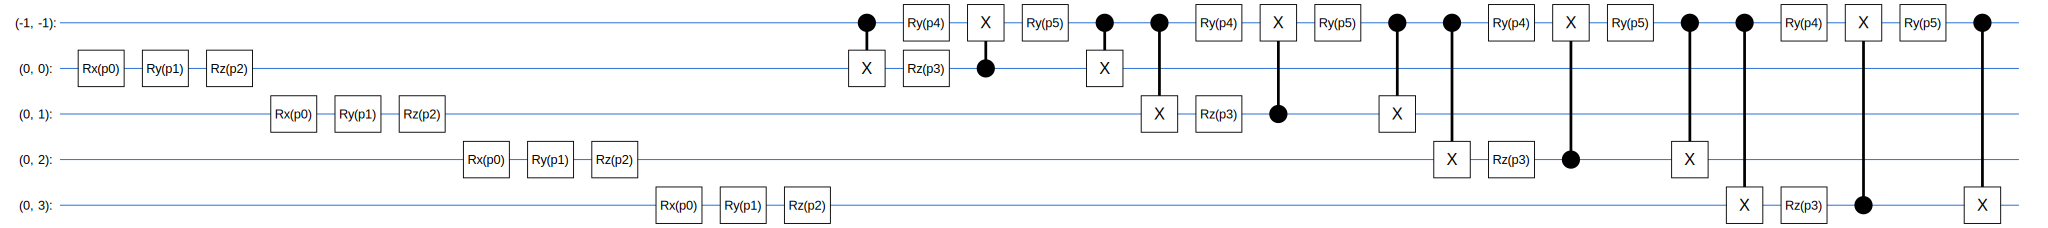

In [47]:
model, quantum_model_circuit, qubits, readoutqubit = setup(n, param, cnot=False, full=False, extra=False)

SVGCircuit(quantum_model_circuit)

In [6]:
def train(model, train_excitations, train_labels, optimizer, loss_fn, loss_list, epochs=100):
    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))


        with tf.GradientTape() as tape:
            logits = model(train_excitations, training=True)  # Logits for this minibatch

            loss_value = tf.math.reduce_mean(loss_fn(train_labels, tf.squeeze(logits)))

        grads = tape.gradient(loss_value, model.trainable_weights)

        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        loss_list.append(loss_value)
        print(
            "Training loss at epoch %d: %.4f"
            % (epoch, float(loss_value)) )#, tf.squeeze(grads)
        
        

def trainStoch(model, train_excitations, train_labels, optimizer, loss_fn, loss_list, epochs=100):
    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))
        
        loss_value = 0
        for it in range(len(train_excitations)):
            with tf.GradientTape() as tape:
                logits = model(train_excitations[it:it+1], training=True)  # Logits for this minibatch

                loss_value += tf.math.reduce_mean(loss_fn(train_labels[it:it+1], tf.squeeze(logits)))

            grads = tape.gradient(loss_value, model.trainable_weights)

            optimizer.apply_gradients(zip(grads, model.trainable_weights))

        loss_list.append(loss_value)
        print(
            "Training loss at epoch %d: %.4f"
            % (epoch, float(loss_value)) )#, tf.squeeze(grads)

In [26]:
N = 4
loss = []
optimizer = tf.keras.optimizers.Adam(learning_rate=0.02*16)#*16, momentum=0.0, nesterov=False)
loss_fn = tf.losses.mse

model, quantum_model_circuit, qubits, readoutqubit = setup(N, param, extra=False, full=False, cnot=False, firstOne=False, random=True, depth=10)
inputs, labels = generate_data(qubits)

ninp = len(inputs)
split = int(ninp*1)

train_excitations = inputs[:split]
train_labels = labels[:split]
#train_labels = tf.cast(train_labels, dtype=tf.float64)

test_excitations = inputs[split:]
test_labels = labels[split:]



print(model.weights)


"""batch_size = 16
train_dataset = tf.data.Dataset.from_tensor_slices((train_excitations, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)"""


loss_list = []

epochs = 100
train(model, train_excitations, train_labels, optimizer, loss_fn, loss_list, epochs=epochs)



[<tf.Variable 'parameters:0' shape=(3,) dtype=float32, numpy=array([1.2069665, 0.7347753, 4.448836 ], dtype=float32)>]

Start of epoch 0
Training loss at epoch 0: 0.5712

Start of epoch 1
Training loss at epoch 1: 0.5227

Start of epoch 2
Training loss at epoch 2: 0.8800

Start of epoch 3
Training loss at epoch 3: 0.3892

Start of epoch 4
Training loss at epoch 4: 0.7586

Start of epoch 5
Training loss at epoch 5: 0.2753

Start of epoch 6
Training loss at epoch 6: 0.5071

Start of epoch 7
Training loss at epoch 7: 0.4943

Start of epoch 8
Training loss at epoch 8: 0.2384

Start of epoch 9
Training loss at epoch 9: 0.4855

Start of epoch 10
Training loss at epoch 10: 0.3415

Start of epoch 11
Training loss at epoch 11: 0.2489

Start of epoch 12
Training loss at epoch 12: 0.3860

Start of epoch 13
Training loss at epoch 13: 0.3048

Start of epoch 14
Training loss at epoch 14: 0.2460

Start of epoch 15
Training loss at epoch 15: 0.3271

Start of epoch 16
Training loss at epoch 16: 0.3266


[array([ 0.27320945,  1.8422512 , -0.09350289], dtype=float32)]


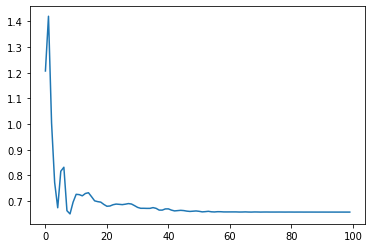

In [19]:
print(model.get_weights())
plt.plot(loss_list)


In [367]:
lossQibo = [0.8134540832112808, 0.8004845937249053, 0.7901812498055115, 0.7819870147510053, 0.7752587399759246, 0.7695522037850754, 0.7646230684685612, 0.7603432877852007, 0.756635901099241, 0.7534420509637819, 0.750708179834802, 0.748382510650672, 0.746414989495453, 0.7447581684102412, 0.7433680880025803, 0.7422048789841038, 0.7412330506899176, 0.7404215167552599, 0.7397434266533349, 0.7391758677925437, 0.7386994919701643, 0.7382981079198171, 0.7379582705109862, 0.7376688875587532, 0.7374208573773592, 0.7372067441370928, 0.7370204936115126, 0.7368571888083588, 0.7367128430051665, 0.7365842266002967, 0.7364687237051988, 0.736364214344357, 0.7362689783376, 0.7361816172976794, 0.7361009916017273, 0.7360261696339826, 0.7359563870158335, 0.7358910139196445, 0.7358295288971546, 0.735771497939924, 0.7357165577307939, 0.7356644022458887, 0.735614772031505, 0.7355674456145271, 0.7355222326137257, 0.7354789682068363, 0.735437508678535, 0.735397727830555, 0.7353595140799772, 0.7353227681073529, 0.7352874009446607, 0.735253332415619, 0.7352204898587245, 0.7351888070775807, 0.735158223474331, 0.7351286833309401, 0.7351001352101635, 0.7350725314536736, 0.7350458277593005, 0.7350199828228978, 0.7349949580331908, 0.7349707172102277, 0.7349472263798533, 0.7349244535780843, 0.7349023686803988, 0.7348809432519077, 0.734860150415093, 0.7348399647324189, 0.7348203621015847, 0.734801319661602, 0.7347828157081698, 0.7347648296170929, 0.7347473417746969, 0.7347303335143556, 0.7347137870583897, 0.734697685464714, 0.7346820125776982, 0.7346667529827832, 0.7346518919644689, 0.7346374154673316, 0.7346233100597783, 0.7346095629002857, 0.7345961617058994, 0.7345830947227975, 0.7345703506987417, 0.7345579188572674, 0.7345457888734687, 0.7345339508512595, 0.7345223953019978, 0.7345111131243727, 0.7345000955854646, 0.7344893343028962, 0.7344788212279977, 0.7344685486299178, 0.734458509080621, 0.7344486954407062, 0.7344391008460024, 0.7344297186948858, 0.7344205426362757, 0.7344115665582648, 0.7344027845773506, 0.7343941910282258, 0.7343857804540964, 0.7343775475974983, 0.7343694873915794, 0.7343615949518238, 0.7343538655681909, 0.7343462946976443, 0.7343388779570539, 0.7343316111164415, 0.7343244900925618, 0.7343175109427892, 0.7343106698593005, 0.7343039631635386, 0.7342973873009342, 0.7342909388358814, 0.734284614446944, 0.7342784109222913, 0.7342723251553381, 0.7342663541405933, 0.734260494969689, 0.7342547448276008, 0.7342491009890294, 0.7342435608149492, 0.7342381217493126, 0.7342327813158949, 0.7342275371152847, 0.7342223868220015, 0.7342173281817411, 0.7342123590087404, 0.7342074771832533, 0.7342026806491397, 0.7341979674115516, 0.73419333553472, 0.7341887831398349, 0.7341843084030135, 0.7341799095533525, 0.7341755848710622, 0.7341713326856755, 0.7341671513743323, 0.734163039360132, 0.7341589951105534, 0.7341550171359377, 0.7341511039880315, 0.7341472542585907, 0.734143466578036, 0.7341397396141618, 0.7341360720708988, 0.7341324626871203, 0.7341289102354984, 0.7341254135214008, 0.7341219713818334, 0.7341185826844195, 0.7341152463264203, 0.7341119612337917, 0.7341087263602746, 0.7341055406865211, 0.7341024032192531, 0.7340993129904505, 0.7340962690565687, 0.7340932704977879, 0.7340903164172852, 0.7340874059405373, 0.7340845382146428, 0.7340817124076755, 0.7340789277080543, 0.7340761833239388, 0.7340734784826453, 0.7340708124300837, 0.734068184430212, 0.7340655937645125, 0.7340630397314841, 0.7340605216461519, 0.7340580388395939, 0.7340555906584855, 0.7340531764646553, 0.7340507956346595, 0.7340484475593682, 0.7340461316435668, 0.7340438473055706, 0.73404159397685, 0.7340393711016703, 0.734037178136742, 0.7340350145508828, 0.7340328798246902, 0.7340307734502247, 0.7340286949307028, 0.7340266437802008, 0.7340246195233662, 0.7340226216951391, 0.7340206498404831, 0.7340187035141237, 0.7340167822802925, 0.734014885712485, 0.7340130133932193, 0.7340111649138077, 0.734009339874131, 0.7340075378824209, 0.734005758555052, 0.734004001516334]

#print(loss_list)

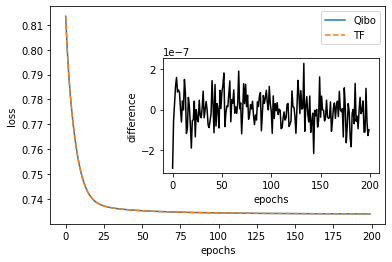

In [446]:
#plt.plot(np.abs(np.array(loss_list)-np.array(lossQibo)))

fig, ax1 = plt.subplots()

plt.xlabel("epochs")
plt.ylabel("loss")

left, bottom, width, height = [0.385, 0.3, 0.5, 0.4]
ax2 = fig.add_axes([left, bottom, width, height])

ax1.plot(loss_list[:200], label='Qibo')
ax1.plot(lossQibo[:200], '--', label='TF')

ax2.plot(np.array(loss_list)-np.array(lossQibo), 'k')

ax1.legend()

plt.xlabel("epochs")
plt.ylabel("difference")
plt.savefig("compare.pdf")


In [436]:
#qcnn_model.predict(train_excitations)

N = 6

lossp = []
loss = []

losspF = []
lossF = []

lossp_ = []
loss_ = []

losspF_ = []
lossF_ = []

loss_fn = tf.losses.mse

#optimizer=tf.keras.optimizers.SGD(learning_rate=0.01*16, momentum=0.0, nesterov=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)
    
for n in range(1,N+1):
    model, quantum_model_circuit, qubits, readoutqubit = setup(n, param, extra=False, full=True, cnot=True)
    inputs, labels = generate_data(qubits)

    ninp = len(inputs)
    split = int(ninp*1)

    train_excitations = inputs[:split]
    train_labels = labels[:split]
    #train_labels = tf.cast(train_labels, dtype=tf.float64)

    test_excitations = inputs[split:]
    test_labels = labels[split:]

    print(model.weights)

    

    """batch_size = 16
    train_dataset = tf.data.Dataset.from_tensor_slices((train_excitations, train_labels))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)"""

    
    loss_list = []

    epochs = 75
    train(model, train_excitations, train_labels, optimizer, loss_fn, loss_list, epochs=epochs)
    
    loss.append(loss_list)
    
    loss_list = []
    model, quantum_model_circuit, qubits, readoutqubit = setup(n, param, extra=False, full=True, cnot=True)
    inputs, labels = generate_data_p(qubits)
    train(model, inputs, labels, optimizer, loss_fn, loss_list, epochs=epochs)
    lossp.append(loss_list)
    
    
    loss_list = []
    model, quantum_model_circuit, qubits, readoutqubit = setup(n, param, extra=False, full=False, cnot=True)
    inputs, labels = generate_data_p(qubits)
    train(model, inputs, labels, optimizer, loss_fn, loss_list, epochs=epochs)
    losspF.append(loss_list)
    
    loss_list = []
    model, quantum_model_circuit, qubits, readoutqubit = setup(n, param, extra=False, full=False, cnot=True)
    inputs, labels = generate_data(qubits)
    train(model, inputs, labels, optimizer, loss_fn, loss_list, epochs=epochs)
    lossF.append(loss_list)
    
    
    
    
    loss_list = []

    
    model, quantum_model_circuit, qubits, readoutqubit = setup(n, param, extra=False, full=True, cnot=False)
    train(model, train_excitations, train_labels, optimizer, loss_fn, loss_list, epochs=epochs)
    
    loss_.append(loss_list)
    
    loss_list = []
    model, quantum_model_circuit, qubits, readoutqubit = setup(n, param, extra=False, full=True, cnot=False)
    inputs, labels = generate_data_p(qubits)
    train(model, inputs, labels, optimizer, loss_fn, loss_list, epochs=epochs)
    lossp_.append(loss_list)
    
    
    loss_list = []
    model, quantum_model_circuit, qubits, readoutqubit = setup(n, param, extra=False, full=False, cnot=False)
    inputs, labels = generate_data_p(qubits)
    train(model, inputs, labels, optimizer, loss_fn, loss_list, epochs=epochs)
    losspF_.append(loss_list)
    
    loss_list = []
    model, quantum_model_circuit, qubits, readoutqubit = setup(n, param, extra=False, full=False, cnot=False)
    inputs, labels = generate_data(qubits)
    train(model, inputs, labels, optimizer, loss_fn, loss_list, epochs=epochs)
    lossF_.append(loss_list)
    
    

[<tf.Variable 'parameters:0' shape=(18,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.], dtype=float32)>]

Start of epoch 0
Training loss at epoch 0: 2.5205

Start of epoch 1
Training loss at epoch 1: 2.3512

Start of epoch 2
Training loss at epoch 2: 2.1767

Start of epoch 3
Training loss at epoch 3: 1.9995

Start of epoch 4
Training loss at epoch 4: 1.8219

Start of epoch 5
Training loss at epoch 5: 1.6464

Start of epoch 6
Training loss at epoch 6: 1.4754

Start of epoch 7
Training loss at epoch 7: 1.3112

Start of epoch 8
Training loss at epoch 8: 1.1559

Start of epoch 9
Training loss at epoch 9: 1.0112

Start of epoch 10
Training loss at epoch 10: 0.8787

Start of epoch 11
Training loss at epoch 11: 0.7592

Start of epoch 12
Training loss at epoch 12: 0.6530

Start of epoch 13
Training loss at epoch 13: 0.5602

Start of epoch 14
Training loss at epoch 14: 0.4799

Start of epoch 15
Training loss at epoch 15: 0.4113

Star

Training loss at epoch 12: 0.3589

Start of epoch 13
Training loss at epoch 13: 0.2517

Start of epoch 14
Training loss at epoch 14: 0.1702

Start of epoch 15
Training loss at epoch 15: 0.1110

Start of epoch 16
Training loss at epoch 16: 0.0698

Start of epoch 17
Training loss at epoch 17: 0.0423

Start of epoch 18
Training loss at epoch 18: 0.0247

Start of epoch 19
Training loss at epoch 19: 0.0139

Start of epoch 20
Training loss at epoch 20: 0.0075

Start of epoch 21
Training loss at epoch 21: 0.0039

Start of epoch 22
Training loss at epoch 22: 0.0019

Start of epoch 23
Training loss at epoch 23: 0.0009

Start of epoch 24
Training loss at epoch 24: 0.0004

Start of epoch 25
Training loss at epoch 25: 0.0002

Start of epoch 26
Training loss at epoch 26: 0.0001

Start of epoch 27
Training loss at epoch 27: 0.0000

Start of epoch 28
Training loss at epoch 28: 0.0000

Start of epoch 29
Training loss at epoch 29: 0.0000

Start of epoch 30
Training loss at epoch 30: 0.0000

Start of ep

Training loss at epoch 18: 0.0054

Start of epoch 19
Training loss at epoch 19: 0.0039

Start of epoch 20
Training loss at epoch 20: 0.0029

Start of epoch 21
Training loss at epoch 21: 0.0022

Start of epoch 22
Training loss at epoch 22: 0.0018

Start of epoch 23
Training loss at epoch 23: 0.0016

Start of epoch 24
Training loss at epoch 24: 0.0016

Start of epoch 25
Training loss at epoch 25: 0.0016

Start of epoch 26
Training loss at epoch 26: 0.0017

Start of epoch 27
Training loss at epoch 27: 0.0019

Start of epoch 28
Training loss at epoch 28: 0.0021

Start of epoch 29
Training loss at epoch 29: 0.0023

Start of epoch 30
Training loss at epoch 30: 0.0025

Start of epoch 31
Training loss at epoch 31: 0.0026

Start of epoch 32
Training loss at epoch 32: 0.0027

Start of epoch 33
Training loss at epoch 33: 0.0027

Start of epoch 34
Training loss at epoch 34: 0.0026

Start of epoch 35
Training loss at epoch 35: 0.0025

Start of epoch 36
Training loss at epoch 36: 0.0024

Start of ep

Training loss at epoch 28: 0.0185

Start of epoch 29
Training loss at epoch 29: 0.0195

Start of epoch 30
Training loss at epoch 30: 0.0198

Start of epoch 31
Training loss at epoch 31: 0.0196

Start of epoch 32
Training loss at epoch 32: 0.0189

Start of epoch 33
Training loss at epoch 33: 0.0178

Start of epoch 34
Training loss at epoch 34: 0.0164

Start of epoch 35
Training loss at epoch 35: 0.0149

Start of epoch 36
Training loss at epoch 36: 0.0133

Start of epoch 37
Training loss at epoch 37: 0.0117

Start of epoch 38
Training loss at epoch 38: 0.0102

Start of epoch 39
Training loss at epoch 39: 0.0088

Start of epoch 40
Training loss at epoch 40: 0.0075

Start of epoch 41
Training loss at epoch 41: 0.0064

Start of epoch 42
Training loss at epoch 42: 0.0054

Start of epoch 43
Training loss at epoch 43: 0.0046

Start of epoch 44
Training loss at epoch 44: 0.0039

Start of epoch 45
Training loss at epoch 45: 0.0032

Start of epoch 46
Training loss at epoch 46: 0.0027

Start of ep

Training loss at epoch 36: 0.1046

Start of epoch 37
Training loss at epoch 37: 0.1011

Start of epoch 38
Training loss at epoch 38: 0.0985

Start of epoch 39
Training loss at epoch 39: 0.0966

Start of epoch 40
Training loss at epoch 40: 0.0953

Start of epoch 41
Training loss at epoch 41: 0.0945

Start of epoch 42
Training loss at epoch 42: 0.0940

Start of epoch 43
Training loss at epoch 43: 0.0937

Start of epoch 44
Training loss at epoch 44: 0.0934

Start of epoch 45
Training loss at epoch 45: 0.0930

Start of epoch 46
Training loss at epoch 46: 0.0924

Start of epoch 47
Training loss at epoch 47: 0.0917

Start of epoch 48
Training loss at epoch 48: 0.0908

Start of epoch 49
Training loss at epoch 49: 0.0899

Start of epoch 50
Training loss at epoch 50: 0.0890

Start of epoch 51
Training loss at epoch 51: 0.0881

Start of epoch 52
Training loss at epoch 52: 0.0874

Start of epoch 53
Training loss at epoch 53: 0.0870

Start of epoch 54
Training loss at epoch 54: 0.0868

Start of ep

Training loss at epoch 46: 0.0000

Start of epoch 47
Training loss at epoch 47: 0.0000

Start of epoch 48
Training loss at epoch 48: 0.0000

Start of epoch 49
Training loss at epoch 49: 0.0000

Start of epoch 50
Training loss at epoch 50: 0.0000

Start of epoch 51
Training loss at epoch 51: 0.0000

Start of epoch 52
Training loss at epoch 52: 0.0000

Start of epoch 53
Training loss at epoch 53: 0.0000

Start of epoch 54
Training loss at epoch 54: 0.0000

Start of epoch 55
Training loss at epoch 55: 0.0000

Start of epoch 56
Training loss at epoch 56: 0.0000

Start of epoch 57
Training loss at epoch 57: 0.0000

Start of epoch 58
Training loss at epoch 58: 0.0000

Start of epoch 59
Training loss at epoch 59: 0.0000

Start of epoch 60
Training loss at epoch 60: 0.0000

Start of epoch 61
Training loss at epoch 61: 0.0000

Start of epoch 62
Training loss at epoch 62: 0.0000

Start of epoch 63
Training loss at epoch 63: 0.0000

Start of epoch 64
Training loss at epoch 64: 0.0000

Start of ep

Training loss at epoch 55: 0.0889

Start of epoch 56
Training loss at epoch 56: 0.0899

Start of epoch 57
Training loss at epoch 57: 0.0907

Start of epoch 58
Training loss at epoch 58: 0.0904

Start of epoch 59
Training loss at epoch 59: 0.0893

Start of epoch 60
Training loss at epoch 60: 0.0881

Start of epoch 61
Training loss at epoch 61: 0.0875

Start of epoch 62
Training loss at epoch 62: 0.0877

Start of epoch 63
Training loss at epoch 63: 0.0883

Start of epoch 64
Training loss at epoch 64: 0.0886

Start of epoch 65
Training loss at epoch 65: 0.0884

Start of epoch 66
Training loss at epoch 66: 0.0877

Start of epoch 67
Training loss at epoch 67: 0.0871

Start of epoch 68
Training loss at epoch 68: 0.0869

Start of epoch 69
Training loss at epoch 69: 0.0870

Start of epoch 70
Training loss at epoch 70: 0.0871

Start of epoch 71
Training loss at epoch 71: 0.0871

Start of epoch 72
Training loss at epoch 72: 0.0869

Start of epoch 73
Training loss at epoch 73: 0.0865

Start of ep

Training loss at epoch 62: 0.2731

Start of epoch 63
Training loss at epoch 63: 0.2704

Start of epoch 64
Training loss at epoch 64: 0.2680

Start of epoch 65
Training loss at epoch 65: 0.2658

Start of epoch 66
Training loss at epoch 66: 0.2638

Start of epoch 67
Training loss at epoch 67: 0.2621

Start of epoch 68
Training loss at epoch 68: 0.2606

Start of epoch 69
Training loss at epoch 69: 0.2592

Start of epoch 70
Training loss at epoch 70: 0.2579

Start of epoch 71
Training loss at epoch 71: 0.2567

Start of epoch 72
Training loss at epoch 72: 0.2556

Start of epoch 73
Training loss at epoch 73: 0.2546

Start of epoch 74
Training loss at epoch 74: 0.2538

Start of epoch 0
Training loss at epoch 0: 0.6096

Start of epoch 1
Training loss at epoch 1: 0.5669

Start of epoch 2
Training loss at epoch 2: 0.5404

Start of epoch 3
Training loss at epoch 3: 0.5419

Start of epoch 4
Training loss at epoch 4: 0.5565

Start of epoch 5
Training loss at epoch 5: 0.5672

Start of epoch 6
Traini

Training loss at epoch 68: 0.1720

Start of epoch 69
Training loss at epoch 69: 0.1553

Start of epoch 70
Training loss at epoch 70: 0.1429

Start of epoch 71
Training loss at epoch 71: 0.1346

Start of epoch 72
Training loss at epoch 72: 0.1284

Start of epoch 73
Training loss at epoch 73: 0.1217

Start of epoch 74
Training loss at epoch 74: 0.1140

Start of epoch 0
Training loss at epoch 0: 0.5312

Start of epoch 1
Training loss at epoch 1: 0.3666

Start of epoch 2
Training loss at epoch 2: 0.3028

Start of epoch 3
Training loss at epoch 3: 0.1362

Start of epoch 4
Training loss at epoch 4: 0.0468

Start of epoch 5
Training loss at epoch 5: 0.0326

Start of epoch 6
Training loss at epoch 6: 0.0209

Start of epoch 7
Training loss at epoch 7: 0.0072

Start of epoch 8
Training loss at epoch 8: 0.0022

Start of epoch 9
Training loss at epoch 9: 0.0028

Start of epoch 10
Training loss at epoch 10: 0.0099

Start of epoch 11
Training loss at epoch 11: 0.0266

Start of epoch 12
Training loss

Training loss at epoch 3: 0.3539

Start of epoch 4
Training loss at epoch 4: 0.3588

Start of epoch 5
Training loss at epoch 5: 0.3627

Start of epoch 6
Training loss at epoch 6: 0.3535

Start of epoch 7
Training loss at epoch 7: 0.3346

Start of epoch 8
Training loss at epoch 8: 0.3161

Start of epoch 9
Training loss at epoch 9: 0.3072

Start of epoch 10
Training loss at epoch 10: 0.3110

Start of epoch 11
Training loss at epoch 11: 0.3232

Start of epoch 12
Training loss at epoch 12: 0.3355

Start of epoch 13
Training loss at epoch 13: 0.3404

Start of epoch 14
Training loss at epoch 14: 0.3362

Start of epoch 15
Training loss at epoch 15: 0.3260

Start of epoch 16
Training loss at epoch 16: 0.3154

Start of epoch 17
Training loss at epoch 17: 0.3083

Start of epoch 18
Training loss at epoch 18: 0.3062

Start of epoch 19
Training loss at epoch 19: 0.3076

Start of epoch 20
Training loss at epoch 20: 0.3098

Start of epoch 21
Training loss at epoch 21: 0.3108

Start of epoch 22
Traini

Training loss at epoch 9: 0.6192

Start of epoch 10
Training loss at epoch 10: 0.4544

Start of epoch 11
Training loss at epoch 11: 0.2630

Start of epoch 12
Training loss at epoch 12: 0.1079

Start of epoch 13
Training loss at epoch 13: 0.0293

Start of epoch 14
Training loss at epoch 14: 0.0073

Start of epoch 15
Training loss at epoch 15: 0.0041

Start of epoch 16
Training loss at epoch 16: 0.0056

Start of epoch 17
Training loss at epoch 17: 0.0122

Start of epoch 18
Training loss at epoch 18: 0.0277

Start of epoch 19
Training loss at epoch 19: 0.0431

Start of epoch 20
Training loss at epoch 20: 0.0527

Start of epoch 21
Training loss at epoch 21: 0.0562

Start of epoch 22
Training loss at epoch 22: 0.0505

Start of epoch 23
Training loss at epoch 23: 0.0421

Start of epoch 24
Training loss at epoch 24: 0.0334

Start of epoch 25
Training loss at epoch 25: 0.0254

Start of epoch 26
Training loss at epoch 26: 0.0198

Start of epoch 27
Training loss at epoch 27: 0.0167

Start of epo

Training loss at epoch 22: 0.5966

Start of epoch 23
Training loss at epoch 23: 0.5536

Start of epoch 24
Training loss at epoch 24: 0.5136

Start of epoch 25
Training loss at epoch 25: 0.4869

Start of epoch 26
Training loss at epoch 26: 0.4830

Start of epoch 27
Training loss at epoch 27: 0.4995

Start of epoch 28
Training loss at epoch 28: 0.5167

Start of epoch 29
Training loss at epoch 29: 0.5181

Start of epoch 30
Training loss at epoch 30: 0.5046

Start of epoch 31
Training loss at epoch 31: 0.4870

Start of epoch 32
Training loss at epoch 32: 0.4747

Start of epoch 33
Training loss at epoch 33: 0.4712

Start of epoch 34
Training loss at epoch 34: 0.4744

Start of epoch 35
Training loss at epoch 35: 0.4796

Start of epoch 36
Training loss at epoch 36: 0.4826

Start of epoch 37
Training loss at epoch 37: 0.4813

Start of epoch 38
Training loss at epoch 38: 0.4761

Start of epoch 39
Training loss at epoch 39: 0.4686

Start of epoch 40
Training loss at epoch 40: 0.4618

Start of ep

Training loss at epoch 25: 0.0834

Start of epoch 26
Training loss at epoch 26: 0.0622

Start of epoch 27
Training loss at epoch 27: 0.0425

Start of epoch 28
Training loss at epoch 28: 0.0271

Start of epoch 29
Training loss at epoch 29: 0.0162

Start of epoch 30
Training loss at epoch 30: 0.0091

Start of epoch 31
Training loss at epoch 31: 0.0049

Start of epoch 32
Training loss at epoch 32: 0.0026

Start of epoch 33
Training loss at epoch 33: 0.0015

Start of epoch 34
Training loss at epoch 34: 0.0010

Start of epoch 35
Training loss at epoch 35: 0.0009

Start of epoch 36
Training loss at epoch 36: 0.0010

Start of epoch 37
Training loss at epoch 37: 0.0013

Start of epoch 38
Training loss at epoch 38: 0.0017

Start of epoch 39
Training loss at epoch 39: 0.0022

Start of epoch 40
Training loss at epoch 40: 0.0028

Start of epoch 41
Training loss at epoch 41: 0.0034

Start of epoch 42
Training loss at epoch 42: 0.0039

Start of epoch 43
Training loss at epoch 43: 0.0042

Start of ep

Training loss at epoch 35: 0.7344

Start of epoch 36
Training loss at epoch 36: 0.7344

Start of epoch 37
Training loss at epoch 37: 0.7343

Start of epoch 38
Training loss at epoch 38: 0.7341

Start of epoch 39
Training loss at epoch 39: 0.7341

Start of epoch 40
Training loss at epoch 40: 0.7342

Start of epoch 41
Training loss at epoch 41: 0.7343

Start of epoch 42
Training loss at epoch 42: 0.7342

Start of epoch 43
Training loss at epoch 43: 0.7341

Start of epoch 44
Training loss at epoch 44: 0.7340

Start of epoch 45
Training loss at epoch 45: 0.7339

Start of epoch 46
Training loss at epoch 46: 0.7340

Start of epoch 47
Training loss at epoch 47: 0.7340

Start of epoch 48
Training loss at epoch 48: 0.7340

Start of epoch 49
Training loss at epoch 49: 0.7340

Start of epoch 50
Training loss at epoch 50: 0.7339

Start of epoch 51
Training loss at epoch 51: 0.7339

Start of epoch 52
Training loss at epoch 52: 0.7339

Start of epoch 53
Training loss at epoch 53: 0.7339

Start of ep

Training loss at epoch 42: 0.0010

Start of epoch 43
Training loss at epoch 43: 0.0009

Start of epoch 44
Training loss at epoch 44: 0.0008

Start of epoch 45
Training loss at epoch 45: 0.0007

Start of epoch 46
Training loss at epoch 46: 0.0006

Start of epoch 47
Training loss at epoch 47: 0.0005

Start of epoch 48
Training loss at epoch 48: 0.0004

Start of epoch 49
Training loss at epoch 49: 0.0004

Start of epoch 50
Training loss at epoch 50: 0.0003

Start of epoch 51
Training loss at epoch 51: 0.0003

Start of epoch 52
Training loss at epoch 52: 0.0003

Start of epoch 53
Training loss at epoch 53: 0.0003

Start of epoch 54
Training loss at epoch 54: 0.0003

Start of epoch 55
Training loss at epoch 55: 0.0003

Start of epoch 56
Training loss at epoch 56: 0.0003

Start of epoch 57
Training loss at epoch 57: 0.0003

Start of epoch 58
Training loss at epoch 58: 0.0003

Start of epoch 59
Training loss at epoch 59: 0.0003

Start of epoch 60
Training loss at epoch 60: 0.0003

Start of ep

Training loss at epoch 53: 0.7339

Start of epoch 54
Training loss at epoch 54: 0.7339

Start of epoch 55
Training loss at epoch 55: 0.7339

Start of epoch 56
Training loss at epoch 56: 0.7339

Start of epoch 57
Training loss at epoch 57: 0.7338

Start of epoch 58
Training loss at epoch 58: 0.7338

Start of epoch 59
Training loss at epoch 59: 0.7339

Start of epoch 60
Training loss at epoch 60: 0.7339

Start of epoch 61
Training loss at epoch 61: 0.7339

Start of epoch 62
Training loss at epoch 62: 0.7338

Start of epoch 63
Training loss at epoch 63: 0.7338

Start of epoch 64
Training loss at epoch 64: 0.7338

Start of epoch 65
Training loss at epoch 65: 0.7338

Start of epoch 66
Training loss at epoch 66: 0.7338

Start of epoch 67
Training loss at epoch 67: 0.7338

Start of epoch 68
Training loss at epoch 68: 0.7338

Start of epoch 69
Training loss at epoch 69: 0.7338

Start of epoch 70
Training loss at epoch 70: 0.7338

Start of epoch 71
Training loss at epoch 71: 0.7338

Start of ep

Training loss at epoch 57: 0.0002

Start of epoch 58
Training loss at epoch 58: 0.0001

Start of epoch 59
Training loss at epoch 59: 0.0001

Start of epoch 60
Training loss at epoch 60: 0.0001

Start of epoch 61
Training loss at epoch 61: 0.0001

Start of epoch 62
Training loss at epoch 62: 0.0001

Start of epoch 63
Training loss at epoch 63: 0.0001

Start of epoch 64
Training loss at epoch 64: 0.0001

Start of epoch 65
Training loss at epoch 65: 0.0001

Start of epoch 66
Training loss at epoch 66: 0.0001

Start of epoch 67
Training loss at epoch 67: 0.0001

Start of epoch 68
Training loss at epoch 68: 0.0001

Start of epoch 69
Training loss at epoch 69: 0.0001

Start of epoch 70
Training loss at epoch 70: 0.0001

Start of epoch 71
Training loss at epoch 71: 0.0001

Start of epoch 72
Training loss at epoch 72: 0.0001

Start of epoch 73
Training loss at epoch 73: 0.0000

Start of epoch 74
Training loss at epoch 74: 0.0000

Start of epoch 0
Training loss at epoch 0: 1.4568

Start of epoc

Training loss at epoch 63: 0.4690

Start of epoch 64
Training loss at epoch 64: 0.4627

Start of epoch 65
Training loss at epoch 65: 0.4573

Start of epoch 66
Training loss at epoch 66: 0.4541

Start of epoch 67
Training loss at epoch 67: 0.4535

Start of epoch 68
Training loss at epoch 68: 0.4548

Start of epoch 69
Training loss at epoch 69: 0.4565

Start of epoch 70
Training loss at epoch 70: 0.4568

Start of epoch 71
Training loss at epoch 71: 0.4549

Start of epoch 72
Training loss at epoch 72: 0.4513

Start of epoch 73
Training loss at epoch 73: 0.4475

Start of epoch 74
Training loss at epoch 74: 0.4448

Start of epoch 0
Training loss at epoch 0: 1.6153

Start of epoch 1
Training loss at epoch 1: 1.3396

Start of epoch 2
Training loss at epoch 2: 1.1001

Start of epoch 3
Training loss at epoch 3: 0.9658

Start of epoch 4
Training loss at epoch 4: 0.9444

Start of epoch 5
Training loss at epoch 5: 1.0150

Start of epoch 6
Training loss at epoch 6: 1.0480

Start of epoch 7
Training

Training loss at epoch 69: 0.0003

Start of epoch 70
Training loss at epoch 70: 0.0002

Start of epoch 71
Training loss at epoch 71: 0.0002

Start of epoch 72
Training loss at epoch 72: 0.0002

Start of epoch 73
Training loss at epoch 73: 0.0002

Start of epoch 74
Training loss at epoch 74: 0.0001

Start of epoch 0
Training loss at epoch 0: 1.0972

Start of epoch 1
Training loss at epoch 1: 1.0762

Start of epoch 2
Training loss at epoch 2: 1.0553

Start of epoch 3
Training loss at epoch 3: 1.0423

Start of epoch 4
Training loss at epoch 4: 1.0281

Start of epoch 5
Training loss at epoch 5: 1.0147

Start of epoch 6
Training loss at epoch 6: 1.0055

Start of epoch 7
Training loss at epoch 7: 0.9998

Start of epoch 8
Training loss at epoch 8: 0.9982

Start of epoch 9
Training loss at epoch 9: 0.9999

Start of epoch 10
Training loss at epoch 10: 1.0017

Start of epoch 11
Training loss at epoch 11: 1.0018

Start of epoch 12
Training loss at epoch 12: 1.0008

Start of epoch 13
Training loss

[<tf.Variable 'parameters:0' shape=(18,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.], dtype=float32)>]

Start of epoch 0
Training loss at epoch 0: 1.2750

Start of epoch 1
Training loss at epoch 1: 1.0307

Start of epoch 2
Training loss at epoch 2: 0.9951

Start of epoch 3
Training loss at epoch 3: 0.9297

Start of epoch 4
Training loss at epoch 4: 0.7287

Start of epoch 5
Training loss at epoch 5: 0.7442

Start of epoch 6
Training loss at epoch 6: 0.7240

Start of epoch 7
Training loss at epoch 7: 0.5394

Start of epoch 8
Training loss at epoch 8: 0.6073

Start of epoch 9
Training loss at epoch 9: 0.4415

Start of epoch 10
Training loss at epoch 10: 0.4250

Start of epoch 11
Training loss at epoch 11: 0.4663

Start of epoch 12
Training loss at epoch 12: 0.3588

Start of epoch 13
Training loss at epoch 13: 0.4719

Start of epoch 14
Training loss at epoch 14: 0.4005

Start of epoch 15
Training loss at epoch 15: 0.3463

Star

Training loss at epoch 2: 0.5030

Start of epoch 3
Training loss at epoch 3: 0.2616

Start of epoch 4
Training loss at epoch 4: 0.0746

Start of epoch 5
Training loss at epoch 5: 0.0062

Start of epoch 6
Training loss at epoch 6: 0.0000

Start of epoch 7
Training loss at epoch 7: 0.0014

Start of epoch 8
Training loss at epoch 8: 0.0219

Start of epoch 9
Training loss at epoch 9: 0.0755

Start of epoch 10
Training loss at epoch 10: 0.1330

Start of epoch 11
Training loss at epoch 11: 0.1585

Start of epoch 12
Training loss at epoch 12: 0.1443

Start of epoch 13
Training loss at epoch 13: 0.1044

Start of epoch 14
Training loss at epoch 14: 0.0596

Start of epoch 15
Training loss at epoch 15: 0.0261

Start of epoch 16
Training loss at epoch 16: 0.0083

Start of epoch 17
Training loss at epoch 17: 0.0017

Start of epoch 18
Training loss at epoch 18: 0.0002

Start of epoch 19
Training loss at epoch 19: 0.0000

Start of epoch 20
Training loss at epoch 20: 0.0001

Start of epoch 21
Training

Training loss at epoch 8: 0.3666

Start of epoch 9
Training loss at epoch 9: 0.2539

Start of epoch 10
Training loss at epoch 10: 0.3352

Start of epoch 11
Training loss at epoch 11: 0.3575

Start of epoch 12
Training loss at epoch 12: 0.2814

Start of epoch 13
Training loss at epoch 13: 0.2981

Start of epoch 14
Training loss at epoch 14: 0.3478

Start of epoch 15
Training loss at epoch 15: 0.3021

Start of epoch 16
Training loss at epoch 16: 0.2628

Start of epoch 17
Training loss at epoch 17: 0.2912

Start of epoch 18
Training loss at epoch 18: 0.2722

Start of epoch 19
Training loss at epoch 19: 0.2237

Start of epoch 20
Training loss at epoch 20: 0.2398

Start of epoch 21
Training loss at epoch 21: 0.2500

Start of epoch 22
Training loss at epoch 22: 0.2194

Start of epoch 23
Training loss at epoch 23: 0.2247

Start of epoch 24
Training loss at epoch 24: 0.2397

Start of epoch 25
Training loss at epoch 25: 0.2202

Start of epoch 26
Training loss at epoch 26: 0.2166

Start of epoch

Training loss at epoch 14: 0.9861

Start of epoch 15
Training loss at epoch 15: 0.9763

Start of epoch 16
Training loss at epoch 16: 0.9757

Start of epoch 17
Training loss at epoch 17: 0.9783

Start of epoch 18
Training loss at epoch 18: 0.9750

Start of epoch 19
Training loss at epoch 19: 0.9646

Start of epoch 20
Training loss at epoch 20: 0.9493

Start of epoch 21
Training loss at epoch 21: 0.9338

Start of epoch 22
Training loss at epoch 22: 0.9190

Start of epoch 23
Training loss at epoch 23: 0.9114

Start of epoch 24
Training loss at epoch 24: 0.9151

Start of epoch 25
Training loss at epoch 25: 0.9175

Start of epoch 26
Training loss at epoch 26: 0.9153

Start of epoch 27
Training loss at epoch 27: 0.9137

Start of epoch 28
Training loss at epoch 28: 0.9135

Start of epoch 29
Training loss at epoch 29: 0.9136

Start of epoch 30
Training loss at epoch 30: 0.9150

Start of epoch 31
Training loss at epoch 31: 0.9164

Start of epoch 32
Training loss at epoch 32: 0.9155

Start of ep

In [442]:
_loss = loss

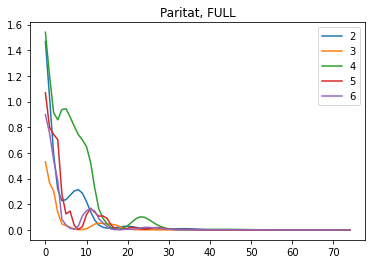

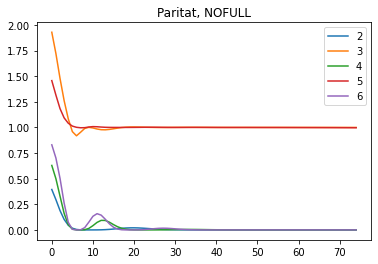

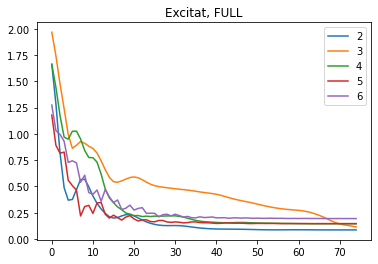

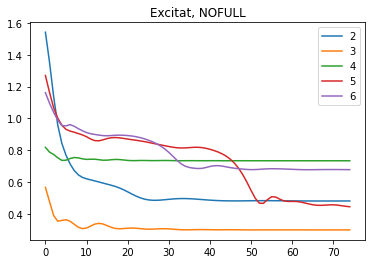

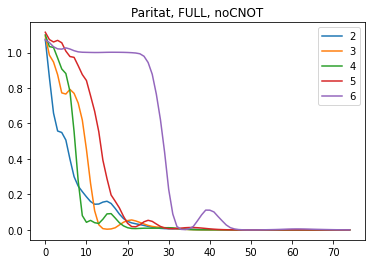

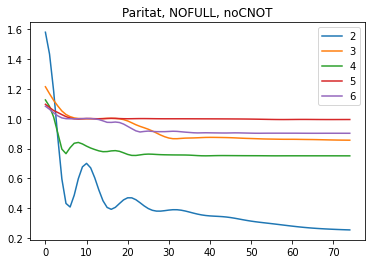

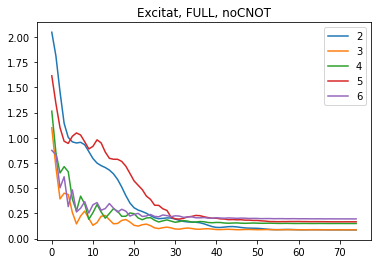

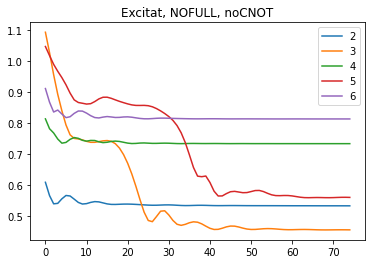

In [581]:
N=6

plt.title("Paritat, FULL")
for n in range(1+1, N+1):
    plt.plot(lossp[n-1], label=str(n))
plt.legend()
plt.show()

plt.title("Paritat, NOFULL")
for n in range(1+1, N+1):
    plt.plot(losspF[n-1], label=str(n))
plt.legend()
plt.show()

plt.title("Excitat, FULL")
for n in range(1+1, N+1):
    plt.plot(_loss[n-1], label=str(n))
plt.legend()
plt.show()

plt.title("Excitat, NOFULL")
for n in range(1+1, N+1):
    plt.plot(lossF[n-1], label=str(n))
plt.legend()
plt.show()





plt.title("Paritat, FULL, noCNOT")
for n in range(1+1, N+1):
    plt.plot(lossp_[n-1], label=str(n))
plt.legend()
plt.show()

plt.title("Paritat, NOFULL, noCNOT")
for n in range(1+1, N+1):
    plt.plot(losspF_[n-1], label=str(n))
plt.legend()
plt.show()

plt.title("Excitat, FULL, noCNOT")
for n in range(1+1, N+1):
    plt.plot(loss_[n-1], label=str(n))
plt.legend()
plt.show()

plt.title("Excitat, NOFULL, noCNOT")
for n in range(1+1, N+1):
    plt.plot(lossF_[n-1], label=str(n))
plt.legend()
plt.show()

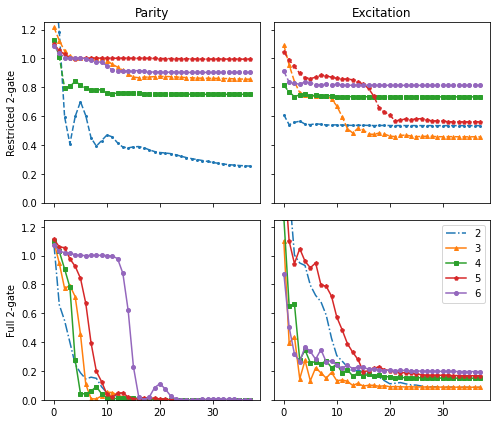

In [690]:
styles = ['.', '^', 's', 'p', 'o']


fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(7,6))

axs[1,0].set_ylim(0, 1.25)
axs[1,1].set_ylim(0, 1.25)
axs[0,0].set_ylim(0, 1.25)
axs[0,1].set_ylim(0, 1.25)

#plt.title("Paritat, FULL, noCNOT")
for n in range(1+1, N+1):
    axs[1,0].plot(lossp_[n-1][::2], '-'+ styles[n-2], label="", markersize=4)#str(n))

#plt.title("Paritat, NOFULL, noCNOT")

axs[0,0].set_title("Parity")
axs[0,0].set_ylabel("Restricted 2-gate")

axs[1,0].set_ylabel("Full 2-gate")

for n in range(1+1, N+1):
    axs[0,0].plot(losspF_[n-1][::2], '--'+ styles[n-2], label="", markersize=4)#)str(n))

#plt.title("Excitat, FULL, noCNOT")
for n in range(1+1, N+1):
    axs[1,1].plot(loss_[n-1][::2], '-'+ styles[n-2], label=str(n), markersize=4)

#plt.title("Excitat, NOFULL, noCNOT")
axs[0,1].set_title("Excitation")
for n in range(1+1, N+1):
    axs[0,1].plot(lossF_[n-1][::2], '--'+ styles[n-2], label="", markersize=4)#str(n))
axs[1,1].legend()

#plt.tight_layout()
for ax in fig.get_axes():
    ax.label_outer()
    
plt.tight_layout()

for _ in axs:
    for ax in _:
        ax.label_outer()
    
plt.savefig('nqubits.pdf')
plt.show()

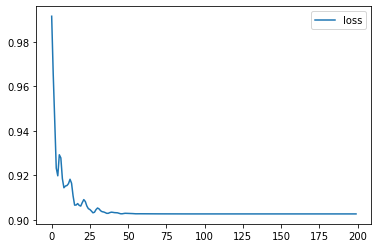

In [246]:
"""print(model(train_excitations))
print(train_labels)

print(loss_fn(train_labels, tf.squeeze(model(train_excitations))))"""

plt.plot(loss_list, label="loss")
plt.legend()

In [184]:
temp = model.trainable_weights
temp

[<tf.Variable 'parameters:0' shape=(6,) dtype=float32, numpy=
array([ 0.95383805,  3.445206  ,  3.0512972 , -0.3224178 ,  2.4567301 ,
       -0.28668672], dtype=float32)>]


[<tf.Variable 'parameters:0' shape=(6,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0.], dtype=float32)>]

In [165]:
model.set_weights(np.array([[0.0,0,0]]))
print(model.trainable_weights)


pred = model(inputs)
print(train_labels)
print(pred)

loss_value = tf.math.reduce_mean(loss_fn(train_labels, tf.squeeze(pred)))
print(loss_value)

SVGCircuit(quantum_model_circuit)

ValueError: Layer model_18 weight shape (6,) is not compatible with provided weight shape (3,).

In [142]:
inputs, labels = generate_data_p(qubits)

"""for el in inputs:
    print(el)"""
    
    
"""print()
print(el)"""

mod = tfq.layers.AddCircuit()(quantum_model_circuit, prepend=inputs[1])

print(tfq.from_tensor(mod)[0])

00

01
(0, 1): ───X───
10
(0, 0): ───X───
11
(0, 0): ───X───

(0, 1): ───X───


InvalidArgumentError: Exception encountered when calling layer "add_circuit_54" (type AddCircuit).

programs must be rank 1. Got rank 0. [Op:TfqAppendCircuit]

Call arguments received:
  • inputs=cirq.Circuit([
    cirq.Moment(
        cirq.CNOT(cirq.GridQubit(0, 0), cirq.GridQubit(-1, -1)),
    ),
    cirq.Moment(
        cirq.CNOT(cirq.GridQubit(0, 1), cirq.GridQubit(-1, -1)),
    ),
])
  • append=None
  • prepend=tf.Tensor(shape=(), dtype=string)

In [129]:
model.predict(train_excitations)

array([[ 1.],
       [ 1.],
       [-1.],
       [-1.]], dtype=float32)

## Results
After comparing and making sure we obtain the same as using qibo, everything being well controlled, we start analyzing more into detail the problems themselves rather than the implementation

Depth training

In [749]:
maxdepth = range(1,5+1)
N = 4

dloss = [[]*6]

for depth in maxdepth:
    dloss.append([])
    for randIt in range(5):
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)#tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False)
        loss_fn = tf.losses.mse

        model, quantum_model_circuit, qubits, readoutqubit = setup(N, param, extra=False, full=True, firstOne=False, cnot=False, depth=depth, random=True)
        inputs, labels = generate_data(qubits)

        ninp = len(inputs)
        split = int(ninp*1)

        train_excitations = inputs[:split]
        train_labels = labels[:split]
        #train_labels = tf.cast(train_labels, dtype=tf.float64)

        test_excitations = inputs[split:]
        test_labels = labels[split:]



        print(model.weights)


        """batch_size = 16
        train_dataset = tf.data.Dataset.from_tensor_slices((train_excitations, train_labels))
        train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)"""


        loss_list = []

        epochs = 500
        train(model, train_excitations, train_labels, optimizer, loss_fn, loss_list, epochs=epochs)
        dloss[-1].append(loss_list)
        

[<tf.Variable 'parameters:0' shape=(15,) dtype=float32, numpy=
array([2.768021 , 2.8349156, 1.3637989, 1.8400033, 5.9047313, 1.706681 ,
       1.4753548, 3.2054064, 3.3112376, 2.343164 , 4.4138837, 5.875032 ,
       2.5824096, 0.6603046, 4.027665 ], dtype=float32)>]

Start of epoch 0
Training loss at epoch 0: 1.3711

Start of epoch 1
Training loss at epoch 1: 1.3255

Start of epoch 2
Training loss at epoch 2: 1.2815

Start of epoch 3
Training loss at epoch 3: 1.2400

Start of epoch 4
Training loss at epoch 4: 1.2013

Start of epoch 5
Training loss at epoch 5: 1.1657

Start of epoch 6
Training loss at epoch 6: 1.1329

Start of epoch 7
Training loss at epoch 7: 1.1026

Start of epoch 8
Training loss at epoch 8: 1.0747

Start of epoch 9
Training loss at epoch 9: 1.0491

Start of epoch 10
Training loss at epoch 10: 1.0257

Start of epoch 11
Training loss at epoch 11: 1.0043

Start of epoch 12
Training loss at epoch 12: 0.9846

Start of epoch 13
Training loss at epoch 13: 0.9664

Start of e

Training loss at epoch 149: 0.1734

Start of epoch 150
Training loss at epoch 150: 0.1724

Start of epoch 151
Training loss at epoch 151: 0.1715

Start of epoch 152
Training loss at epoch 152: 0.1707

Start of epoch 153
Training loss at epoch 153: 0.1699

Start of epoch 154
Training loss at epoch 154: 0.1693

Start of epoch 155
Training loss at epoch 155: 0.1688

Start of epoch 156
Training loss at epoch 156: 0.1682

Start of epoch 157
Training loss at epoch 157: 0.1676

Start of epoch 158
Training loss at epoch 158: 0.1671

Start of epoch 159
Training loss at epoch 159: 0.1666

Start of epoch 160
Training loss at epoch 160: 0.1661

Start of epoch 161
Training loss at epoch 161: 0.1658

Start of epoch 162
Training loss at epoch 162: 0.1656

Start of epoch 163
Training loss at epoch 163: 0.1654

Start of epoch 164
Training loss at epoch 164: 0.1653

Start of epoch 165
Training loss at epoch 165: 0.1651

Start of epoch 166
Training loss at epoch 166: 0.1650

Start of epoch 167
Training l

Training loss at epoch 300: 0.1640

Start of epoch 301
Training loss at epoch 301: 0.1640

Start of epoch 302
Training loss at epoch 302: 0.1640

Start of epoch 303
Training loss at epoch 303: 0.1640

Start of epoch 304
Training loss at epoch 304: 0.1640

Start of epoch 305
Training loss at epoch 305: 0.1640

Start of epoch 306
Training loss at epoch 306: 0.1640

Start of epoch 307
Training loss at epoch 307: 0.1640

Start of epoch 308
Training loss at epoch 308: 0.1640

Start of epoch 309
Training loss at epoch 309: 0.1640

Start of epoch 310
Training loss at epoch 310: 0.1640

Start of epoch 311
Training loss at epoch 311: 0.1640

Start of epoch 312
Training loss at epoch 312: 0.1640

Start of epoch 313
Training loss at epoch 313: 0.1640

Start of epoch 314
Training loss at epoch 314: 0.1640

Start of epoch 315
Training loss at epoch 315: 0.1640

Start of epoch 316
Training loss at epoch 316: 0.1640

Start of epoch 317
Training loss at epoch 317: 0.1640

Start of epoch 318
Training l

Training loss at epoch 450: 0.1639

Start of epoch 451
Training loss at epoch 451: 0.1639

Start of epoch 452
Training loss at epoch 452: 0.1639

Start of epoch 453
Training loss at epoch 453: 0.1639

Start of epoch 454
Training loss at epoch 454: 0.1639

Start of epoch 455
Training loss at epoch 455: 0.1639

Start of epoch 456
Training loss at epoch 456: 0.1639

Start of epoch 457
Training loss at epoch 457: 0.1639

Start of epoch 458
Training loss at epoch 458: 0.1639

Start of epoch 459
Training loss at epoch 459: 0.1639

Start of epoch 460
Training loss at epoch 460: 0.1639

Start of epoch 461
Training loss at epoch 461: 0.1639

Start of epoch 462
Training loss at epoch 462: 0.1639

Start of epoch 463
Training loss at epoch 463: 0.1639

Start of epoch 464
Training loss at epoch 464: 0.1639

Start of epoch 465
Training loss at epoch 465: 0.1639

Start of epoch 466
Training loss at epoch 466: 0.1639

Start of epoch 467
Training loss at epoch 467: 0.1639

Start of epoch 468
Training l

Training loss at epoch 98: 0.1846

Start of epoch 99
Training loss at epoch 99: 0.1832

Start of epoch 100
Training loss at epoch 100: 0.1818

Start of epoch 101
Training loss at epoch 101: 0.1805

Start of epoch 102
Training loss at epoch 102: 0.1792

Start of epoch 103
Training loss at epoch 103: 0.1779

Start of epoch 104
Training loss at epoch 104: 0.1767

Start of epoch 105
Training loss at epoch 105: 0.1756

Start of epoch 106
Training loss at epoch 106: 0.1744

Start of epoch 107
Training loss at epoch 107: 0.1733

Start of epoch 108
Training loss at epoch 108: 0.1722

Start of epoch 109
Training loss at epoch 109: 0.1712

Start of epoch 110
Training loss at epoch 110: 0.1702

Start of epoch 111
Training loss at epoch 111: 0.1692

Start of epoch 112
Training loss at epoch 112: 0.1682

Start of epoch 113
Training loss at epoch 113: 0.1673

Start of epoch 114
Training loss at epoch 114: 0.1664

Start of epoch 115
Training loss at epoch 115: 0.1655

Start of epoch 116
Training loss

Training loss at epoch 253: 0.1496

Start of epoch 254
Training loss at epoch 254: 0.1496

Start of epoch 255
Training loss at epoch 255: 0.1496

Start of epoch 256
Training loss at epoch 256: 0.1496

Start of epoch 257
Training loss at epoch 257: 0.1496

Start of epoch 258
Training loss at epoch 258: 0.1496

Start of epoch 259
Training loss at epoch 259: 0.1496

Start of epoch 260
Training loss at epoch 260: 0.1496

Start of epoch 261
Training loss at epoch 261: 0.1496

Start of epoch 262
Training loss at epoch 262: 0.1496

Start of epoch 263
Training loss at epoch 263: 0.1496

Start of epoch 264
Training loss at epoch 264: 0.1496

Start of epoch 265
Training loss at epoch 265: 0.1496

Start of epoch 266
Training loss at epoch 266: 0.1496

Start of epoch 267
Training loss at epoch 267: 0.1496

Start of epoch 268
Training loss at epoch 268: 0.1496

Start of epoch 269
Training loss at epoch 269: 0.1496

Start of epoch 270
Training loss at epoch 270: 0.1496

Start of epoch 271
Training l

Training loss at epoch 404: 0.1496

Start of epoch 405
Training loss at epoch 405: 0.1496

Start of epoch 406
Training loss at epoch 406: 0.1496

Start of epoch 407
Training loss at epoch 407: 0.1496

Start of epoch 408
Training loss at epoch 408: 0.1496

Start of epoch 409
Training loss at epoch 409: 0.1496

Start of epoch 410
Training loss at epoch 410: 0.1496

Start of epoch 411
Training loss at epoch 411: 0.1496

Start of epoch 412
Training loss at epoch 412: 0.1496

Start of epoch 413
Training loss at epoch 413: 0.1496

Start of epoch 414
Training loss at epoch 414: 0.1496

Start of epoch 415
Training loss at epoch 415: 0.1496

Start of epoch 416
Training loss at epoch 416: 0.1496

Start of epoch 417
Training loss at epoch 417: 0.1496

Start of epoch 418
Training loss at epoch 418: 0.1496

Start of epoch 419
Training loss at epoch 419: 0.1496

Start of epoch 420
Training loss at epoch 420: 0.1496

Start of epoch 421
Training loss at epoch 421: 0.1496

Start of epoch 422
Training l

Training loss at epoch 53: 0.3372

Start of epoch 54
Training loss at epoch 54: 0.3308

Start of epoch 55
Training loss at epoch 55: 0.3242

Start of epoch 56
Training loss at epoch 56: 0.3179

Start of epoch 57
Training loss at epoch 57: 0.3120

Start of epoch 58
Training loss at epoch 58: 0.3054

Start of epoch 59
Training loss at epoch 59: 0.2975

Start of epoch 60
Training loss at epoch 60: 0.2888

Start of epoch 61
Training loss at epoch 61: 0.2799

Start of epoch 62
Training loss at epoch 62: 0.2706

Start of epoch 63
Training loss at epoch 63: 0.2605

Start of epoch 64
Training loss at epoch 64: 0.2499

Start of epoch 65
Training loss at epoch 65: 0.2397

Start of epoch 66
Training loss at epoch 66: 0.2301

Start of epoch 67
Training loss at epoch 67: 0.2205

Start of epoch 68
Training loss at epoch 68: 0.2114

Start of epoch 69
Training loss at epoch 69: 0.2034

Start of epoch 70
Training loss at epoch 70: 0.1965

Start of epoch 71
Training loss at epoch 71: 0.1902

Start of ep

Training loss at epoch 206: 0.1639

Start of epoch 207
Training loss at epoch 207: 0.1639

Start of epoch 208
Training loss at epoch 208: 0.1639

Start of epoch 209
Training loss at epoch 209: 0.1639

Start of epoch 210
Training loss at epoch 210: 0.1639

Start of epoch 211
Training loss at epoch 211: 0.1639

Start of epoch 212
Training loss at epoch 212: 0.1639

Start of epoch 213
Training loss at epoch 213: 0.1639

Start of epoch 214
Training loss at epoch 214: 0.1639

Start of epoch 215
Training loss at epoch 215: 0.1639

Start of epoch 216
Training loss at epoch 216: 0.1639

Start of epoch 217
Training loss at epoch 217: 0.1639

Start of epoch 218
Training loss at epoch 218: 0.1639

Start of epoch 219
Training loss at epoch 219: 0.1639

Start of epoch 220
Training loss at epoch 220: 0.1639

Start of epoch 221
Training loss at epoch 221: 0.1639

Start of epoch 222
Training loss at epoch 222: 0.1639

Start of epoch 223
Training loss at epoch 223: 0.1639

Start of epoch 224
Training l

Training loss at epoch 358: 0.1639

Start of epoch 359
Training loss at epoch 359: 0.1639

Start of epoch 360
Training loss at epoch 360: 0.1639

Start of epoch 361
Training loss at epoch 361: 0.1639

Start of epoch 362
Training loss at epoch 362: 0.1639

Start of epoch 363
Training loss at epoch 363: 0.1639

Start of epoch 364
Training loss at epoch 364: 0.1639

Start of epoch 365
Training loss at epoch 365: 0.1639

Start of epoch 366
Training loss at epoch 366: 0.1639

Start of epoch 367
Training loss at epoch 367: 0.1639

Start of epoch 368
Training loss at epoch 368: 0.1639

Start of epoch 369
Training loss at epoch 369: 0.1639

Start of epoch 370
Training loss at epoch 370: 0.1639

Start of epoch 371
Training loss at epoch 371: 0.1639

Start of epoch 372
Training loss at epoch 372: 0.1639

Start of epoch 373
Training loss at epoch 373: 0.1639

Start of epoch 374
Training loss at epoch 374: 0.1639

Start of epoch 375
Training loss at epoch 375: 0.1639

Start of epoch 376
Training l

Training loss at epoch 3: 0.4732

Start of epoch 4
Training loss at epoch 4: 0.4737

Start of epoch 5
Training loss at epoch 5: 0.4715

Start of epoch 6
Training loss at epoch 6: 0.4526

Start of epoch 7
Training loss at epoch 7: 0.4212

Start of epoch 8
Training loss at epoch 8: 0.3864

Start of epoch 9
Training loss at epoch 9: 0.3563

Start of epoch 10
Training loss at epoch 10: 0.3357

Start of epoch 11
Training loss at epoch 11: 0.3249

Start of epoch 12
Training loss at epoch 12: 0.3203

Start of epoch 13
Training loss at epoch 13: 0.3163

Start of epoch 14
Training loss at epoch 14: 0.3091

Start of epoch 15
Training loss at epoch 15: 0.2983

Start of epoch 16
Training loss at epoch 16: 0.2867

Start of epoch 17
Training loss at epoch 17: 0.2777

Start of epoch 18
Training loss at epoch 18: 0.2738

Start of epoch 19
Training loss at epoch 19: 0.2750

Start of epoch 20
Training loss at epoch 20: 0.2786

Start of epoch 21
Training loss at epoch 21: 0.2813

Start of epoch 22
Traini

Training loss at epoch 157: 0.1650

Start of epoch 158
Training loss at epoch 158: 0.1650

Start of epoch 159
Training loss at epoch 159: 0.1650

Start of epoch 160
Training loss at epoch 160: 0.1650

Start of epoch 161
Training loss at epoch 161: 0.1650

Start of epoch 162
Training loss at epoch 162: 0.1650

Start of epoch 163
Training loss at epoch 163: 0.1649

Start of epoch 164
Training loss at epoch 164: 0.1649

Start of epoch 165
Training loss at epoch 165: 0.1649

Start of epoch 166
Training loss at epoch 166: 0.1649

Start of epoch 167
Training loss at epoch 167: 0.1649

Start of epoch 168
Training loss at epoch 168: 0.1649

Start of epoch 169
Training loss at epoch 169: 0.1649

Start of epoch 170
Training loss at epoch 170: 0.1649

Start of epoch 171
Training loss at epoch 171: 0.1649

Start of epoch 172
Training loss at epoch 172: 0.1648

Start of epoch 173
Training loss at epoch 173: 0.1648

Start of epoch 174
Training loss at epoch 174: 0.1648

Start of epoch 175
Training l

Training loss at epoch 309: 0.1642

Start of epoch 310
Training loss at epoch 310: 0.1642

Start of epoch 311
Training loss at epoch 311: 0.1642

Start of epoch 312
Training loss at epoch 312: 0.1642

Start of epoch 313
Training loss at epoch 313: 0.1642

Start of epoch 314
Training loss at epoch 314: 0.1642

Start of epoch 315
Training loss at epoch 315: 0.1642

Start of epoch 316
Training loss at epoch 316: 0.1642

Start of epoch 317
Training loss at epoch 317: 0.1642

Start of epoch 318
Training loss at epoch 318: 0.1642

Start of epoch 319
Training loss at epoch 319: 0.1642

Start of epoch 320
Training loss at epoch 320: 0.1642

Start of epoch 321
Training loss at epoch 321: 0.1642

Start of epoch 322
Training loss at epoch 322: 0.1642

Start of epoch 323
Training loss at epoch 323: 0.1642

Start of epoch 324
Training loss at epoch 324: 0.1642

Start of epoch 325
Training loss at epoch 325: 0.1642

Start of epoch 326
Training loss at epoch 326: 0.1642

Start of epoch 327
Training l

Training loss at epoch 458: 0.1641

Start of epoch 459
Training loss at epoch 459: 0.1640

Start of epoch 460
Training loss at epoch 460: 0.1640

Start of epoch 461
Training loss at epoch 461: 0.1640

Start of epoch 462
Training loss at epoch 462: 0.1640

Start of epoch 463
Training loss at epoch 463: 0.1640

Start of epoch 464
Training loss at epoch 464: 0.1640

Start of epoch 465
Training loss at epoch 465: 0.1640

Start of epoch 466
Training loss at epoch 466: 0.1640

Start of epoch 467
Training loss at epoch 467: 0.1640

Start of epoch 468
Training loss at epoch 468: 0.1640

Start of epoch 469
Training loss at epoch 469: 0.1640

Start of epoch 470
Training loss at epoch 470: 0.1640

Start of epoch 471
Training loss at epoch 471: 0.1640

Start of epoch 472
Training loss at epoch 472: 0.1640

Start of epoch 473
Training loss at epoch 473: 0.1640

Start of epoch 474
Training loss at epoch 474: 0.1640

Start of epoch 475
Training loss at epoch 475: 0.1640

Start of epoch 476
Training l

Training loss at epoch 106: 0.1685

Start of epoch 107
Training loss at epoch 107: 0.1681

Start of epoch 108
Training loss at epoch 108: 0.1678

Start of epoch 109
Training loss at epoch 109: 0.1676

Start of epoch 110
Training loss at epoch 110: 0.1674

Start of epoch 111
Training loss at epoch 111: 0.1673

Start of epoch 112
Training loss at epoch 112: 0.1671

Start of epoch 113
Training loss at epoch 113: 0.1667

Start of epoch 114
Training loss at epoch 114: 0.1665

Start of epoch 115
Training loss at epoch 115: 0.1663

Start of epoch 116
Training loss at epoch 116: 0.1661

Start of epoch 117
Training loss at epoch 117: 0.1658

Start of epoch 118
Training loss at epoch 118: 0.1657

Start of epoch 119
Training loss at epoch 119: 0.1656

Start of epoch 120
Training loss at epoch 120: 0.1655

Start of epoch 121
Training loss at epoch 121: 0.1653

Start of epoch 122
Training loss at epoch 122: 0.1652

Start of epoch 123
Training loss at epoch 123: 0.1652

Start of epoch 124
Training l

Training loss at epoch 256: 0.1639

Start of epoch 257
Training loss at epoch 257: 0.1639

Start of epoch 258
Training loss at epoch 258: 0.1639

Start of epoch 259
Training loss at epoch 259: 0.1639

Start of epoch 260
Training loss at epoch 260: 0.1639

Start of epoch 261
Training loss at epoch 261: 0.1639

Start of epoch 262
Training loss at epoch 262: 0.1639

Start of epoch 263
Training loss at epoch 263: 0.1639

Start of epoch 264
Training loss at epoch 264: 0.1639

Start of epoch 265
Training loss at epoch 265: 0.1639

Start of epoch 266
Training loss at epoch 266: 0.1639

Start of epoch 267
Training loss at epoch 267: 0.1639

Start of epoch 268
Training loss at epoch 268: 0.1639

Start of epoch 269
Training loss at epoch 269: 0.1639

Start of epoch 270
Training loss at epoch 270: 0.1639

Start of epoch 271
Training loss at epoch 271: 0.1639

Start of epoch 272
Training loss at epoch 272: 0.1639

Start of epoch 273
Training loss at epoch 273: 0.1639

Start of epoch 274
Training l

Training loss at epoch 408: 0.1639

Start of epoch 409
Training loss at epoch 409: 0.1639

Start of epoch 410
Training loss at epoch 410: 0.1639

Start of epoch 411
Training loss at epoch 411: 0.1639

Start of epoch 412
Training loss at epoch 412: 0.1639

Start of epoch 413
Training loss at epoch 413: 0.1639

Start of epoch 414
Training loss at epoch 414: 0.1639

Start of epoch 415
Training loss at epoch 415: 0.1639

Start of epoch 416
Training loss at epoch 416: 0.1639

Start of epoch 417
Training loss at epoch 417: 0.1639

Start of epoch 418
Training loss at epoch 418: 0.1639

Start of epoch 419
Training loss at epoch 419: 0.1639

Start of epoch 420
Training loss at epoch 420: 0.1639

Start of epoch 421
Training loss at epoch 421: 0.1639

Start of epoch 422
Training loss at epoch 422: 0.1639

Start of epoch 423
Training loss at epoch 423: 0.1639

Start of epoch 424
Training loss at epoch 424: 0.1639

Start of epoch 425
Training loss at epoch 425: 0.1639

Start of epoch 426
Training l

Training loss at epoch 52: 0.4092

Start of epoch 53
Training loss at epoch 53: 0.4079

Start of epoch 54
Training loss at epoch 54: 0.4067

Start of epoch 55
Training loss at epoch 55: 0.4055

Start of epoch 56
Training loss at epoch 56: 0.4043

Start of epoch 57
Training loss at epoch 57: 0.4030

Start of epoch 58
Training loss at epoch 58: 0.4015

Start of epoch 59
Training loss at epoch 59: 0.3999

Start of epoch 60
Training loss at epoch 60: 0.3981

Start of epoch 61
Training loss at epoch 61: 0.3961

Start of epoch 62
Training loss at epoch 62: 0.3940

Start of epoch 63
Training loss at epoch 63: 0.3917

Start of epoch 64
Training loss at epoch 64: 0.3893

Start of epoch 65
Training loss at epoch 65: 0.3867

Start of epoch 66
Training loss at epoch 66: 0.3841

Start of epoch 67
Training loss at epoch 67: 0.3814

Start of epoch 68
Training loss at epoch 68: 0.3785

Start of epoch 69
Training loss at epoch 69: 0.3756

Start of epoch 70
Training loss at epoch 70: 0.3727

Start of ep

Training loss at epoch 204: 0.2435

Start of epoch 205
Training loss at epoch 205: 0.2432

Start of epoch 206
Training loss at epoch 206: 0.2429

Start of epoch 207
Training loss at epoch 207: 0.2426

Start of epoch 208
Training loss at epoch 208: 0.2422

Start of epoch 209
Training loss at epoch 209: 0.2419

Start of epoch 210
Training loss at epoch 210: 0.2415

Start of epoch 211
Training loss at epoch 211: 0.2411

Start of epoch 212
Training loss at epoch 212: 0.2407

Start of epoch 213
Training loss at epoch 213: 0.2403

Start of epoch 214
Training loss at epoch 214: 0.2398

Start of epoch 215
Training loss at epoch 215: 0.2393

Start of epoch 216
Training loss at epoch 216: 0.2388

Start of epoch 217
Training loss at epoch 217: 0.2382

Start of epoch 218
Training loss at epoch 218: 0.2376

Start of epoch 219
Training loss at epoch 219: 0.2369

Start of epoch 220
Training loss at epoch 220: 0.2362

Start of epoch 221
Training loss at epoch 221: 0.2353

Start of epoch 222
Training l

Training loss at epoch 353: 0.0246

Start of epoch 354
Training loss at epoch 354: 0.0245

Start of epoch 355
Training loss at epoch 355: 0.0244

Start of epoch 356
Training loss at epoch 356: 0.0243

Start of epoch 357
Training loss at epoch 357: 0.0241

Start of epoch 358
Training loss at epoch 358: 0.0240

Start of epoch 359
Training loss at epoch 359: 0.0239

Start of epoch 360
Training loss at epoch 360: 0.0238

Start of epoch 361
Training loss at epoch 361: 0.0237

Start of epoch 362
Training loss at epoch 362: 0.0236

Start of epoch 363
Training loss at epoch 363: 0.0235

Start of epoch 364
Training loss at epoch 364: 0.0234

Start of epoch 365
Training loss at epoch 365: 0.0233

Start of epoch 366
Training loss at epoch 366: 0.0232

Start of epoch 367
Training loss at epoch 367: 0.0231

Start of epoch 368
Training loss at epoch 368: 0.0230

Start of epoch 369
Training loss at epoch 369: 0.0229

Start of epoch 370
Training loss at epoch 370: 0.0228

Start of epoch 371
Training l

Training loss at epoch 1: 0.7071

Start of epoch 2
Training loss at epoch 2: 0.6820

Start of epoch 3
Training loss at epoch 3: 0.6663

Start of epoch 4
Training loss at epoch 4: 0.6534

Start of epoch 5
Training loss at epoch 5: 0.6399

Start of epoch 6
Training loss at epoch 6: 0.6247

Start of epoch 7
Training loss at epoch 7: 0.6083

Start of epoch 8
Training loss at epoch 8: 0.5921

Start of epoch 9
Training loss at epoch 9: 0.5770

Start of epoch 10
Training loss at epoch 10: 0.5636

Start of epoch 11
Training loss at epoch 11: 0.5515

Start of epoch 12
Training loss at epoch 12: 0.5401

Start of epoch 13
Training loss at epoch 13: 0.5289

Start of epoch 14
Training loss at epoch 14: 0.5181

Start of epoch 15
Training loss at epoch 15: 0.5080

Start of epoch 16
Training loss at epoch 16: 0.4987

Start of epoch 17
Training loss at epoch 17: 0.4903

Start of epoch 18
Training loss at epoch 18: 0.4828

Start of epoch 19
Training loss at epoch 19: 0.4759

Start of epoch 20
Training l

Training loss at epoch 155: 0.3329

Start of epoch 156
Training loss at epoch 156: 0.3302

Start of epoch 157
Training loss at epoch 157: 0.3276

Start of epoch 158
Training loss at epoch 158: 0.3251

Start of epoch 159
Training loss at epoch 159: 0.3225

Start of epoch 160
Training loss at epoch 160: 0.3197

Start of epoch 161
Training loss at epoch 161: 0.3169

Start of epoch 162
Training loss at epoch 162: 0.3140

Start of epoch 163
Training loss at epoch 163: 0.3112

Start of epoch 164
Training loss at epoch 164: 0.3084

Start of epoch 165
Training loss at epoch 165: 0.3059

Start of epoch 166
Training loss at epoch 166: 0.3036

Start of epoch 167
Training loss at epoch 167: 0.3016

Start of epoch 168
Training loss at epoch 168: 0.2999

Start of epoch 169
Training loss at epoch 169: 0.2983

Start of epoch 170
Training loss at epoch 170: 0.2969

Start of epoch 171
Training loss at epoch 171: 0.2954

Start of epoch 172
Training loss at epoch 172: 0.2939

Start of epoch 173
Training l

Training loss at epoch 304: 0.0297

Start of epoch 305
Training loss at epoch 305: 0.0296

Start of epoch 306
Training loss at epoch 306: 0.0295

Start of epoch 307
Training loss at epoch 307: 0.0294

Start of epoch 308
Training loss at epoch 308: 0.0294

Start of epoch 309
Training loss at epoch 309: 0.0293

Start of epoch 310
Training loss at epoch 310: 0.0292

Start of epoch 311
Training loss at epoch 311: 0.0291

Start of epoch 312
Training loss at epoch 312: 0.0291

Start of epoch 313
Training loss at epoch 313: 0.0290

Start of epoch 314
Training loss at epoch 314: 0.0289

Start of epoch 315
Training loss at epoch 315: 0.0288

Start of epoch 316
Training loss at epoch 316: 0.0288

Start of epoch 317
Training loss at epoch 317: 0.0287

Start of epoch 318
Training loss at epoch 318: 0.0286

Start of epoch 319
Training loss at epoch 319: 0.0286

Start of epoch 320
Training loss at epoch 320: 0.0285

Start of epoch 321
Training loss at epoch 321: 0.0284

Start of epoch 322
Training l

Training loss at epoch 453: 0.0241

Start of epoch 454
Training loss at epoch 454: 0.0241

Start of epoch 455
Training loss at epoch 455: 0.0241

Start of epoch 456
Training loss at epoch 456: 0.0241

Start of epoch 457
Training loss at epoch 457: 0.0241

Start of epoch 458
Training loss at epoch 458: 0.0241

Start of epoch 459
Training loss at epoch 459: 0.0241

Start of epoch 460
Training loss at epoch 460: 0.0241

Start of epoch 461
Training loss at epoch 461: 0.0241

Start of epoch 462
Training loss at epoch 462: 0.0241

Start of epoch 463
Training loss at epoch 463: 0.0241

Start of epoch 464
Training loss at epoch 464: 0.0241

Start of epoch 465
Training loss at epoch 465: 0.0241

Start of epoch 466
Training loss at epoch 466: 0.0241

Start of epoch 467
Training loss at epoch 467: 0.0241

Start of epoch 468
Training loss at epoch 468: 0.0241

Start of epoch 469
Training loss at epoch 469: 0.0241

Start of epoch 470
Training loss at epoch 470: 0.0241

Start of epoch 471
Training l

Training loss at epoch 96: 0.4119

Start of epoch 97
Training loss at epoch 97: 0.4117

Start of epoch 98
Training loss at epoch 98: 0.4115

Start of epoch 99
Training loss at epoch 99: 0.4113

Start of epoch 100
Training loss at epoch 100: 0.4111

Start of epoch 101
Training loss at epoch 101: 0.4109

Start of epoch 102
Training loss at epoch 102: 0.4107

Start of epoch 103
Training loss at epoch 103: 0.4105

Start of epoch 104
Training loss at epoch 104: 0.4103

Start of epoch 105
Training loss at epoch 105: 0.4101

Start of epoch 106
Training loss at epoch 106: 0.4099

Start of epoch 107
Training loss at epoch 107: 0.4097

Start of epoch 108
Training loss at epoch 108: 0.4095

Start of epoch 109
Training loss at epoch 109: 0.4092

Start of epoch 110
Training loss at epoch 110: 0.4090

Start of epoch 111
Training loss at epoch 111: 0.4088

Start of epoch 112
Training loss at epoch 112: 0.4085

Start of epoch 113
Training loss at epoch 113: 0.4082

Start of epoch 114
Training loss at 

Training loss at epoch 248: 0.0376

Start of epoch 249
Training loss at epoch 249: 0.0376

Start of epoch 250
Training loss at epoch 250: 0.0376

Start of epoch 251
Training loss at epoch 251: 0.0375

Start of epoch 252
Training loss at epoch 252: 0.0375

Start of epoch 253
Training loss at epoch 253: 0.0375

Start of epoch 254
Training loss at epoch 254: 0.0375

Start of epoch 255
Training loss at epoch 255: 0.0375

Start of epoch 256
Training loss at epoch 256: 0.0375

Start of epoch 257
Training loss at epoch 257: 0.0374

Start of epoch 258
Training loss at epoch 258: 0.0374

Start of epoch 259
Training loss at epoch 259: 0.0374

Start of epoch 260
Training loss at epoch 260: 0.0374

Start of epoch 261
Training loss at epoch 261: 0.0374

Start of epoch 262
Training loss at epoch 262: 0.0374

Start of epoch 263
Training loss at epoch 263: 0.0374

Start of epoch 264
Training loss at epoch 264: 0.0374

Start of epoch 265
Training loss at epoch 265: 0.0374

Start of epoch 266
Training l

Training loss at epoch 397: 0.0374

Start of epoch 398
Training loss at epoch 398: 0.0374

Start of epoch 399
Training loss at epoch 399: 0.0374

Start of epoch 400
Training loss at epoch 400: 0.0374

Start of epoch 401
Training loss at epoch 401: 0.0374

Start of epoch 402
Training loss at epoch 402: 0.0374

Start of epoch 403
Training loss at epoch 403: 0.0374

Start of epoch 404
Training loss at epoch 404: 0.0374

Start of epoch 405
Training loss at epoch 405: 0.0374

Start of epoch 406
Training loss at epoch 406: 0.0374

Start of epoch 407
Training loss at epoch 407: 0.0374

Start of epoch 408
Training loss at epoch 408: 0.0374

Start of epoch 409
Training loss at epoch 409: 0.0374

Start of epoch 410
Training loss at epoch 410: 0.0374

Start of epoch 411
Training loss at epoch 411: 0.0374

Start of epoch 412
Training loss at epoch 412: 0.0374

Start of epoch 413
Training loss at epoch 413: 0.0374

Start of epoch 414
Training loss at epoch 414: 0.0374

Start of epoch 415
Training l

Training loss at epoch 40: 0.4845

Start of epoch 41
Training loss at epoch 41: 0.4824

Start of epoch 42
Training loss at epoch 42: 0.4802

Start of epoch 43
Training loss at epoch 43: 0.4780

Start of epoch 44
Training loss at epoch 44: 0.4759

Start of epoch 45
Training loss at epoch 45: 0.4737

Start of epoch 46
Training loss at epoch 46: 0.4716

Start of epoch 47
Training loss at epoch 47: 0.4695

Start of epoch 48
Training loss at epoch 48: 0.4674

Start of epoch 49
Training loss at epoch 49: 0.4651

Start of epoch 50
Training loss at epoch 50: 0.4628

Start of epoch 51
Training loss at epoch 51: 0.4604

Start of epoch 52
Training loss at epoch 52: 0.4580

Start of epoch 53
Training loss at epoch 53: 0.4554

Start of epoch 54
Training loss at epoch 54: 0.4526

Start of epoch 55
Training loss at epoch 55: 0.4497

Start of epoch 56
Training loss at epoch 56: 0.4465

Start of epoch 57
Training loss at epoch 57: 0.4433

Start of epoch 58
Training loss at epoch 58: 0.4400

Start of ep

Training loss at epoch 193: 0.0237

Start of epoch 194
Training loss at epoch 194: 0.0237

Start of epoch 195
Training loss at epoch 195: 0.0237

Start of epoch 196
Training loss at epoch 196: 0.0236

Start of epoch 197
Training loss at epoch 197: 0.0236

Start of epoch 198
Training loss at epoch 198: 0.0236

Start of epoch 199
Training loss at epoch 199: 0.0236

Start of epoch 200
Training loss at epoch 200: 0.0236

Start of epoch 201
Training loss at epoch 201: 0.0236

Start of epoch 202
Training loss at epoch 202: 0.0236

Start of epoch 203
Training loss at epoch 203: 0.0236

Start of epoch 204
Training loss at epoch 204: 0.0236

Start of epoch 205
Training loss at epoch 205: 0.0236

Start of epoch 206
Training loss at epoch 206: 0.0235

Start of epoch 207
Training loss at epoch 207: 0.0235

Start of epoch 208
Training loss at epoch 208: 0.0235

Start of epoch 209
Training loss at epoch 209: 0.0235

Start of epoch 210
Training loss at epoch 210: 0.0235

Start of epoch 211
Training l

Training loss at epoch 343: 0.0234

Start of epoch 344
Training loss at epoch 344: 0.0234

Start of epoch 345
Training loss at epoch 345: 0.0234

Start of epoch 346
Training loss at epoch 346: 0.0234

Start of epoch 347
Training loss at epoch 347: 0.0234

Start of epoch 348
Training loss at epoch 348: 0.0234

Start of epoch 349
Training loss at epoch 349: 0.0234

Start of epoch 350
Training loss at epoch 350: 0.0234

Start of epoch 351
Training loss at epoch 351: 0.0234

Start of epoch 352
Training loss at epoch 352: 0.0234

Start of epoch 353
Training loss at epoch 353: 0.0234

Start of epoch 354
Training loss at epoch 354: 0.0234

Start of epoch 355
Training loss at epoch 355: 0.0234

Start of epoch 356
Training loss at epoch 356: 0.0234

Start of epoch 357
Training loss at epoch 357: 0.0234

Start of epoch 358
Training loss at epoch 358: 0.0234

Start of epoch 359
Training loss at epoch 359: 0.0234

Start of epoch 360
Training loss at epoch 360: 0.0234

Start of epoch 361
Training l

Training loss at epoch 493: 0.0234

Start of epoch 494
Training loss at epoch 494: 0.0234

Start of epoch 495
Training loss at epoch 495: 0.0234

Start of epoch 496
Training loss at epoch 496: 0.0234

Start of epoch 497
Training loss at epoch 497: 0.0234

Start of epoch 498
Training loss at epoch 498: 0.0234

Start of epoch 499
Training loss at epoch 499: 0.0234
[<tf.Variable 'parameters:0' shape=(30,) dtype=float32, numpy=
array([5.6575117 , 3.9597633 , 6.2687287 , 4.888274  , 3.1408737 ,
       4.9928217 , 5.2683372 , 2.3658824 , 5.943661  , 4.2407327 ,
       3.9086566 , 0.10747303, 0.09524313, 1.2860872 , 1.3299464 ,
       2.2904327 , 4.700449  , 2.864579  , 2.921292  , 4.212913  ,
       2.1378427 , 0.9577658 , 1.5126871 , 5.745279  , 3.145406  ,
       0.8027274 , 0.8230953 , 0.3883024 , 4.393838  , 4.9080787 ],
      dtype=float32)>]

Start of epoch 0
Training loss at epoch 0: 1.2257

Start of epoch 1
Training loss at epoch 1: 1.1295

Start of epoch 2
Training loss at epoch 2: 

Training loss at epoch 138: 0.0816

Start of epoch 139
Training loss at epoch 139: 0.0815

Start of epoch 140
Training loss at epoch 140: 0.0813

Start of epoch 141
Training loss at epoch 141: 0.0811

Start of epoch 142
Training loss at epoch 142: 0.0810

Start of epoch 143
Training loss at epoch 143: 0.0808

Start of epoch 144
Training loss at epoch 144: 0.0806

Start of epoch 145
Training loss at epoch 145: 0.0805

Start of epoch 146
Training loss at epoch 146: 0.0803

Start of epoch 147
Training loss at epoch 147: 0.0801

Start of epoch 148
Training loss at epoch 148: 0.0799

Start of epoch 149
Training loss at epoch 149: 0.0797

Start of epoch 150
Training loss at epoch 150: 0.0796

Start of epoch 151
Training loss at epoch 151: 0.0794

Start of epoch 152
Training loss at epoch 152: 0.0792

Start of epoch 153
Training loss at epoch 153: 0.0790

Start of epoch 154
Training loss at epoch 154: 0.0788

Start of epoch 155
Training loss at epoch 155: 0.0786

Start of epoch 156
Training l

Training loss at epoch 288: 0.0591

Start of epoch 289
Training loss at epoch 289: 0.0591

Start of epoch 290
Training loss at epoch 290: 0.0591

Start of epoch 291
Training loss at epoch 291: 0.0590

Start of epoch 292
Training loss at epoch 292: 0.0590

Start of epoch 293
Training loss at epoch 293: 0.0590

Start of epoch 294
Training loss at epoch 294: 0.0590

Start of epoch 295
Training loss at epoch 295: 0.0590

Start of epoch 296
Training loss at epoch 296: 0.0590

Start of epoch 297
Training loss at epoch 297: 0.0590

Start of epoch 298
Training loss at epoch 298: 0.0589

Start of epoch 299
Training loss at epoch 299: 0.0589

Start of epoch 300
Training loss at epoch 300: 0.0589

Start of epoch 301
Training loss at epoch 301: 0.0589

Start of epoch 302
Training loss at epoch 302: 0.0589

Start of epoch 303
Training loss at epoch 303: 0.0589

Start of epoch 304
Training loss at epoch 304: 0.0589

Start of epoch 305
Training loss at epoch 305: 0.0589

Start of epoch 306
Training l

Training loss at epoch 437: 0.0583

Start of epoch 438
Training loss at epoch 438: 0.0583

Start of epoch 439
Training loss at epoch 439: 0.0583

Start of epoch 440
Training loss at epoch 440: 0.0583

Start of epoch 441
Training loss at epoch 441: 0.0583

Start of epoch 442
Training loss at epoch 442: 0.0583

Start of epoch 443
Training loss at epoch 443: 0.0583

Start of epoch 444
Training loss at epoch 444: 0.0583

Start of epoch 445
Training loss at epoch 445: 0.0583

Start of epoch 446
Training loss at epoch 446: 0.0583

Start of epoch 447
Training loss at epoch 447: 0.0583

Start of epoch 448
Training loss at epoch 448: 0.0583

Start of epoch 449
Training loss at epoch 449: 0.0583

Start of epoch 450
Training loss at epoch 450: 0.0583

Start of epoch 451
Training loss at epoch 451: 0.0583

Start of epoch 452
Training loss at epoch 452: 0.0583

Start of epoch 453
Training loss at epoch 453: 0.0583

Start of epoch 454
Training loss at epoch 454: 0.0583

Start of epoch 455
Training l

Training loss at epoch 78: 0.3541

Start of epoch 79
Training loss at epoch 79: 0.3529

Start of epoch 80
Training loss at epoch 80: 0.3517

Start of epoch 81
Training loss at epoch 81: 0.3506

Start of epoch 82
Training loss at epoch 82: 0.3496

Start of epoch 83
Training loss at epoch 83: 0.3485

Start of epoch 84
Training loss at epoch 84: 0.3475

Start of epoch 85
Training loss at epoch 85: 0.3464

Start of epoch 86
Training loss at epoch 86: 0.3454

Start of epoch 87
Training loss at epoch 87: 0.3444

Start of epoch 88
Training loss at epoch 88: 0.3435

Start of epoch 89
Training loss at epoch 89: 0.3425

Start of epoch 90
Training loss at epoch 90: 0.3416

Start of epoch 91
Training loss at epoch 91: 0.3407

Start of epoch 92
Training loss at epoch 92: 0.3398

Start of epoch 93
Training loss at epoch 93: 0.3389

Start of epoch 94
Training loss at epoch 94: 0.3380

Start of epoch 95
Training loss at epoch 95: 0.3371

Start of epoch 96
Training loss at epoch 96: 0.3362

Start of ep

Training loss at epoch 228: 0.3073

Start of epoch 229
Training loss at epoch 229: 0.3072

Start of epoch 230
Training loss at epoch 230: 0.3072

Start of epoch 231
Training loss at epoch 231: 0.3071

Start of epoch 232
Training loss at epoch 232: 0.3071

Start of epoch 233
Training loss at epoch 233: 0.3070

Start of epoch 234
Training loss at epoch 234: 0.3070

Start of epoch 235
Training loss at epoch 235: 0.3069

Start of epoch 236
Training loss at epoch 236: 0.3069

Start of epoch 237
Training loss at epoch 237: 0.3068

Start of epoch 238
Training loss at epoch 238: 0.3068

Start of epoch 239
Training loss at epoch 239: 0.3067

Start of epoch 240
Training loss at epoch 240: 0.3067

Start of epoch 241
Training loss at epoch 241: 0.3066

Start of epoch 242
Training loss at epoch 242: 0.3066

Start of epoch 243
Training loss at epoch 243: 0.3065

Start of epoch 244
Training loss at epoch 244: 0.3065

Start of epoch 245
Training loss at epoch 245: 0.3064

Start of epoch 246
Training l

Training loss at epoch 378: 0.2933

Start of epoch 379
Training loss at epoch 379: 0.2931

Start of epoch 380
Training loss at epoch 380: 0.2929

Start of epoch 381
Training loss at epoch 381: 0.2927

Start of epoch 382
Training loss at epoch 382: 0.2925

Start of epoch 383
Training loss at epoch 383: 0.2923

Start of epoch 384
Training loss at epoch 384: 0.2921

Start of epoch 385
Training loss at epoch 385: 0.2919

Start of epoch 386
Training loss at epoch 386: 0.2917

Start of epoch 387
Training loss at epoch 387: 0.2915

Start of epoch 388
Training loss at epoch 388: 0.2913

Start of epoch 389
Training loss at epoch 389: 0.2912

Start of epoch 390
Training loss at epoch 390: 0.2910

Start of epoch 391
Training loss at epoch 391: 0.2908

Start of epoch 392
Training loss at epoch 392: 0.2906

Start of epoch 393
Training loss at epoch 393: 0.2904

Start of epoch 394
Training loss at epoch 394: 0.2902

Start of epoch 395
Training loss at epoch 395: 0.2900

Start of epoch 396
Training l

Training loss at epoch 17: 0.6088

Start of epoch 18
Training loss at epoch 18: 0.5890

Start of epoch 19
Training loss at epoch 19: 0.5698

Start of epoch 20
Training loss at epoch 20: 0.5522

Start of epoch 21
Training loss at epoch 21: 0.5367

Start of epoch 22
Training loss at epoch 22: 0.5232

Start of epoch 23
Training loss at epoch 23: 0.5112

Start of epoch 24
Training loss at epoch 24: 0.5006

Start of epoch 25
Training loss at epoch 25: 0.4913

Start of epoch 26
Training loss at epoch 26: 0.4835

Start of epoch 27
Training loss at epoch 27: 0.4772

Start of epoch 28
Training loss at epoch 28: 0.4719

Start of epoch 29
Training loss at epoch 29: 0.4671

Start of epoch 30
Training loss at epoch 30: 0.4625

Start of epoch 31
Training loss at epoch 31: 0.4579

Start of epoch 32
Training loss at epoch 32: 0.4536

Start of epoch 33
Training loss at epoch 33: 0.4499

Start of epoch 34
Training loss at epoch 34: 0.4469

Start of epoch 35
Training loss at epoch 35: 0.4445

Start of ep

Training loss at epoch 169: 0.3120

Start of epoch 170
Training loss at epoch 170: 0.3116

Start of epoch 171
Training loss at epoch 171: 0.3111

Start of epoch 172
Training loss at epoch 172: 0.3107

Start of epoch 173
Training loss at epoch 173: 0.3103

Start of epoch 174
Training loss at epoch 174: 0.3099

Start of epoch 175
Training loss at epoch 175: 0.3095

Start of epoch 176
Training loss at epoch 176: 0.3091

Start of epoch 177
Training loss at epoch 177: 0.3087

Start of epoch 178
Training loss at epoch 178: 0.3083

Start of epoch 179
Training loss at epoch 179: 0.3080

Start of epoch 180
Training loss at epoch 180: 0.3076

Start of epoch 181
Training loss at epoch 181: 0.3073

Start of epoch 182
Training loss at epoch 182: 0.3069

Start of epoch 183
Training loss at epoch 183: 0.3066

Start of epoch 184
Training loss at epoch 184: 0.3062

Start of epoch 185
Training loss at epoch 185: 0.3059

Start of epoch 186
Training loss at epoch 186: 0.3056

Start of epoch 187
Training l

Training loss at epoch 319: 0.0957

Start of epoch 320
Training loss at epoch 320: 0.0954

Start of epoch 321
Training loss at epoch 321: 0.0953

Start of epoch 322
Training loss at epoch 322: 0.0953

Start of epoch 323
Training loss at epoch 323: 0.0953

Start of epoch 324
Training loss at epoch 324: 0.0953

Start of epoch 325
Training loss at epoch 325: 0.0953

Start of epoch 326
Training loss at epoch 326: 0.0953

Start of epoch 327
Training loss at epoch 327: 0.0952

Start of epoch 328
Training loss at epoch 328: 0.0951

Start of epoch 329
Training loss at epoch 329: 0.0950

Start of epoch 330
Training loss at epoch 330: 0.0949

Start of epoch 331
Training loss at epoch 331: 0.0947

Start of epoch 332
Training loss at epoch 332: 0.0945

Start of epoch 333
Training loss at epoch 333: 0.0943

Start of epoch 334
Training loss at epoch 334: 0.0941

Start of epoch 335
Training loss at epoch 335: 0.0940

Start of epoch 336
Training loss at epoch 336: 0.0938

Start of epoch 337
Training l

Training loss at epoch 469: 0.0826

Start of epoch 470
Training loss at epoch 470: 0.0824

Start of epoch 471
Training loss at epoch 471: 0.0823

Start of epoch 472
Training loss at epoch 472: 0.0821

Start of epoch 473
Training loss at epoch 473: 0.0820

Start of epoch 474
Training loss at epoch 474: 0.0818

Start of epoch 475
Training loss at epoch 475: 0.0816

Start of epoch 476
Training loss at epoch 476: 0.0815

Start of epoch 477
Training loss at epoch 477: 0.0813

Start of epoch 478
Training loss at epoch 478: 0.0811

Start of epoch 479
Training loss at epoch 479: 0.0809

Start of epoch 480
Training loss at epoch 480: 0.0807

Start of epoch 481
Training loss at epoch 481: 0.0805

Start of epoch 482
Training loss at epoch 482: 0.0803

Start of epoch 483
Training loss at epoch 483: 0.0801

Start of epoch 484
Training loss at epoch 484: 0.0799

Start of epoch 485
Training loss at epoch 485: 0.0797

Start of epoch 486
Training loss at epoch 486: 0.0794

Start of epoch 487
Training l

Training loss at epoch 111: 0.4044

Start of epoch 112
Training loss at epoch 112: 0.4022

Start of epoch 113
Training loss at epoch 113: 0.3998

Start of epoch 114
Training loss at epoch 114: 0.3972

Start of epoch 115
Training loss at epoch 115: 0.3944

Start of epoch 116
Training loss at epoch 116: 0.3914

Start of epoch 117
Training loss at epoch 117: 0.3882

Start of epoch 118
Training loss at epoch 118: 0.3848

Start of epoch 119
Training loss at epoch 119: 0.3813

Start of epoch 120
Training loss at epoch 120: 0.3776

Start of epoch 121
Training loss at epoch 121: 0.3738

Start of epoch 122
Training loss at epoch 122: 0.3699

Start of epoch 123
Training loss at epoch 123: 0.3659

Start of epoch 124
Training loss at epoch 124: 0.3619

Start of epoch 125
Training loss at epoch 125: 0.3580

Start of epoch 126
Training loss at epoch 126: 0.3540

Start of epoch 127
Training loss at epoch 127: 0.3502

Start of epoch 128
Training loss at epoch 128: 0.3464

Start of epoch 129
Training l

Training loss at epoch 261: 0.0864

Start of epoch 262
Training loss at epoch 262: 0.0857

Start of epoch 263
Training loss at epoch 263: 0.0850

Start of epoch 264
Training loss at epoch 264: 0.0842

Start of epoch 265
Training loss at epoch 265: 0.0834

Start of epoch 266
Training loss at epoch 266: 0.0825

Start of epoch 267
Training loss at epoch 267: 0.0818

Start of epoch 268
Training loss at epoch 268: 0.0812

Start of epoch 269
Training loss at epoch 269: 0.0808

Start of epoch 270
Training loss at epoch 270: 0.0805

Start of epoch 271
Training loss at epoch 271: 0.0802

Start of epoch 272
Training loss at epoch 272: 0.0800

Start of epoch 273
Training loss at epoch 273: 0.0796

Start of epoch 274
Training loss at epoch 274: 0.0791

Start of epoch 275
Training loss at epoch 275: 0.0786

Start of epoch 276
Training loss at epoch 276: 0.0781

Start of epoch 277
Training loss at epoch 277: 0.0775

Start of epoch 278
Training loss at epoch 278: 0.0770

Start of epoch 279
Training l

Training loss at epoch 410: 0.0004

Start of epoch 411
Training loss at epoch 411: 0.0004

Start of epoch 412
Training loss at epoch 412: 0.0003

Start of epoch 413
Training loss at epoch 413: 0.0003

Start of epoch 414
Training loss at epoch 414: 0.0003

Start of epoch 415
Training loss at epoch 415: 0.0003

Start of epoch 416
Training loss at epoch 416: 0.0003

Start of epoch 417
Training loss at epoch 417: 0.0003

Start of epoch 418
Training loss at epoch 418: 0.0002

Start of epoch 419
Training loss at epoch 419: 0.0002

Start of epoch 420
Training loss at epoch 420: 0.0002

Start of epoch 421
Training loss at epoch 421: 0.0002

Start of epoch 422
Training loss at epoch 422: 0.0002

Start of epoch 423
Training loss at epoch 423: 0.0002

Start of epoch 424
Training loss at epoch 424: 0.0002

Start of epoch 425
Training loss at epoch 425: 0.0002

Start of epoch 426
Training loss at epoch 426: 0.0002

Start of epoch 427
Training loss at epoch 427: 0.0002

Start of epoch 428
Training l

Training loss at epoch 47: 0.4084

Start of epoch 48
Training loss at epoch 48: 0.4029

Start of epoch 49
Training loss at epoch 49: 0.3974

Start of epoch 50
Training loss at epoch 50: 0.3922

Start of epoch 51
Training loss at epoch 51: 0.3873

Start of epoch 52
Training loss at epoch 52: 0.3827

Start of epoch 53
Training loss at epoch 53: 0.3781

Start of epoch 54
Training loss at epoch 54: 0.3735

Start of epoch 55
Training loss at epoch 55: 0.3687

Start of epoch 56
Training loss at epoch 56: 0.3638

Start of epoch 57
Training loss at epoch 57: 0.3589

Start of epoch 58
Training loss at epoch 58: 0.3541

Start of epoch 59
Training loss at epoch 59: 0.3495

Start of epoch 60
Training loss at epoch 60: 0.3450

Start of epoch 61
Training loss at epoch 61: 0.3407

Start of epoch 62
Training loss at epoch 62: 0.3363

Start of epoch 63
Training loss at epoch 63: 0.3319

Start of epoch 64
Training loss at epoch 64: 0.3274

Start of epoch 65
Training loss at epoch 65: 0.3229

Start of ep

Training loss at epoch 199: 0.0273

Start of epoch 200
Training loss at epoch 200: 0.0262

Start of epoch 201
Training loss at epoch 201: 0.0253

Start of epoch 202
Training loss at epoch 202: 0.0244

Start of epoch 203
Training loss at epoch 203: 0.0236

Start of epoch 204
Training loss at epoch 204: 0.0228

Start of epoch 205
Training loss at epoch 205: 0.0220

Start of epoch 206
Training loss at epoch 206: 0.0213

Start of epoch 207
Training loss at epoch 207: 0.0206

Start of epoch 208
Training loss at epoch 208: 0.0200

Start of epoch 209
Training loss at epoch 209: 0.0194

Start of epoch 210
Training loss at epoch 210: 0.0189

Start of epoch 211
Training loss at epoch 211: 0.0184

Start of epoch 212
Training loss at epoch 212: 0.0179

Start of epoch 213
Training loss at epoch 213: 0.0175

Start of epoch 214
Training loss at epoch 214: 0.0171

Start of epoch 215
Training loss at epoch 215: 0.0168

Start of epoch 216
Training loss at epoch 216: 0.0164

Start of epoch 217
Training l

Training loss at epoch 349: 0.0113

Start of epoch 350
Training loss at epoch 350: 0.0113

Start of epoch 351
Training loss at epoch 351: 0.0113

Start of epoch 352
Training loss at epoch 352: 0.0113

Start of epoch 353
Training loss at epoch 353: 0.0113

Start of epoch 354
Training loss at epoch 354: 0.0113

Start of epoch 355
Training loss at epoch 355: 0.0113

Start of epoch 356
Training loss at epoch 356: 0.0113

Start of epoch 357
Training loss at epoch 357: 0.0113

Start of epoch 358
Training loss at epoch 358: 0.0113

Start of epoch 359
Training loss at epoch 359: 0.0113

Start of epoch 360
Training loss at epoch 360: 0.0113

Start of epoch 361
Training loss at epoch 361: 0.0113

Start of epoch 362
Training loss at epoch 362: 0.0113

Start of epoch 363
Training loss at epoch 363: 0.0113

Start of epoch 364
Training loss at epoch 364: 0.0113

Start of epoch 365
Training loss at epoch 365: 0.0113

Start of epoch 366
Training loss at epoch 366: 0.0113

Start of epoch 367
Training l

Training loss at epoch 498: 0.0109

Start of epoch 499
Training loss at epoch 499: 0.0109
[<tf.Variable 'parameters:0' shape=(45,) dtype=float32, numpy=
array([4.413902  , 3.2594337 , 1.6420096 , 6.0265784 , 4.204766  ,
       3.3882782 , 4.154652  , 4.364699  , 4.6481214 , 2.2949185 ,
       0.5467091 , 1.3336256 , 0.23033606, 4.367606  , 2.0513084 ,
       6.039899  , 0.25356522, 0.783047  , 5.763462  , 2.4026597 ,
       5.688776  , 4.673912  , 3.136343  , 1.8514235 , 3.7299125 ,
       2.9297123 , 2.2152152 , 5.5722003 , 0.5953119 , 2.1137087 ,
       0.7793866 , 1.4733894 , 0.11701622, 1.1896957 , 0.4166226 ,
       2.4342277 , 4.965727  , 4.6106253 , 5.8579283 , 3.454339  ,
       2.3726144 , 2.8436844 , 4.0736914 , 4.228277  , 4.437603  ],
      dtype=float32)>]

Start of epoch 0
Training loss at epoch 0: 1.0633

Start of epoch 1
Training loss at epoch 1: 0.9622

Start of epoch 2
Training loss at epoch 2: 0.8777

Start of epoch 3
Training loss at epoch 3: 0.8195

Start of epoch 

Training loss at epoch 140: 0.2554

Start of epoch 141
Training loss at epoch 141: 0.2549

Start of epoch 142
Training loss at epoch 142: 0.2545

Start of epoch 143
Training loss at epoch 143: 0.2541

Start of epoch 144
Training loss at epoch 144: 0.2537

Start of epoch 145
Training loss at epoch 145: 0.2533

Start of epoch 146
Training loss at epoch 146: 0.2529

Start of epoch 147
Training loss at epoch 147: 0.2525

Start of epoch 148
Training loss at epoch 148: 0.2522

Start of epoch 149
Training loss at epoch 149: 0.2518

Start of epoch 150
Training loss at epoch 150: 0.2515

Start of epoch 151
Training loss at epoch 151: 0.2512

Start of epoch 152
Training loss at epoch 152: 0.2509

Start of epoch 153
Training loss at epoch 153: 0.2506

Start of epoch 154
Training loss at epoch 154: 0.2503

Start of epoch 155
Training loss at epoch 155: 0.2501

Start of epoch 156
Training loss at epoch 156: 0.2498

Start of epoch 157
Training loss at epoch 157: 0.2496

Start of epoch 158
Training l

Training loss at epoch 289: 0.2363

Start of epoch 290
Training loss at epoch 290: 0.2362

Start of epoch 291
Training loss at epoch 291: 0.2361

Start of epoch 292
Training loss at epoch 292: 0.2361

Start of epoch 293
Training loss at epoch 293: 0.2360

Start of epoch 294
Training loss at epoch 294: 0.2359

Start of epoch 295
Training loss at epoch 295: 0.2358

Start of epoch 296
Training loss at epoch 296: 0.2357

Start of epoch 297
Training loss at epoch 297: 0.2357

Start of epoch 298
Training loss at epoch 298: 0.2356

Start of epoch 299
Training loss at epoch 299: 0.2355

Start of epoch 300
Training loss at epoch 300: 0.2354

Start of epoch 301
Training loss at epoch 301: 0.2353

Start of epoch 302
Training loss at epoch 302: 0.2352

Start of epoch 303
Training loss at epoch 303: 0.2350

Start of epoch 304
Training loss at epoch 304: 0.2349

Start of epoch 305
Training loss at epoch 305: 0.2348

Start of epoch 306
Training loss at epoch 306: 0.2347

Start of epoch 307
Training l

Training loss at epoch 438: 0.0548

Start of epoch 439
Training loss at epoch 439: 0.0548

Start of epoch 440
Training loss at epoch 440: 0.0548

Start of epoch 441
Training loss at epoch 441: 0.0548

Start of epoch 442
Training loss at epoch 442: 0.0548

Start of epoch 443
Training loss at epoch 443: 0.0548

Start of epoch 444
Training loss at epoch 444: 0.0548

Start of epoch 445
Training loss at epoch 445: 0.0547

Start of epoch 446
Training loss at epoch 446: 0.0547

Start of epoch 447
Training loss at epoch 447: 0.0547

Start of epoch 448
Training loss at epoch 448: 0.0547

Start of epoch 449
Training loss at epoch 449: 0.0547

Start of epoch 450
Training loss at epoch 450: 0.0547

Start of epoch 451
Training loss at epoch 451: 0.0547

Start of epoch 452
Training loss at epoch 452: 0.0547

Start of epoch 453
Training loss at epoch 453: 0.0547

Start of epoch 454
Training loss at epoch 454: 0.0547

Start of epoch 455
Training loss at epoch 455: 0.0546

Start of epoch 456
Training l

Training loss at epoch 74: 0.3378

Start of epoch 75
Training loss at epoch 75: 0.3366

Start of epoch 76
Training loss at epoch 76: 0.3355

Start of epoch 77
Training loss at epoch 77: 0.3344

Start of epoch 78
Training loss at epoch 78: 0.3333

Start of epoch 79
Training loss at epoch 79: 0.3323

Start of epoch 80
Training loss at epoch 80: 0.3313

Start of epoch 81
Training loss at epoch 81: 0.3304

Start of epoch 82
Training loss at epoch 82: 0.3294

Start of epoch 83
Training loss at epoch 83: 0.3285

Start of epoch 84
Training loss at epoch 84: 0.3276

Start of epoch 85
Training loss at epoch 85: 0.3267

Start of epoch 86
Training loss at epoch 86: 0.3258

Start of epoch 87
Training loss at epoch 87: 0.3248

Start of epoch 88
Training loss at epoch 88: 0.3239

Start of epoch 89
Training loss at epoch 89: 0.3230

Start of epoch 90
Training loss at epoch 90: 0.3221

Start of epoch 91
Training loss at epoch 91: 0.3211

Start of epoch 92
Training loss at epoch 92: 0.3202

Start of ep

Training loss at epoch 224: 0.2403

Start of epoch 225
Training loss at epoch 225: 0.2398

Start of epoch 226
Training loss at epoch 226: 0.2394

Start of epoch 227
Training loss at epoch 227: 0.2389

Start of epoch 228
Training loss at epoch 228: 0.2384

Start of epoch 229
Training loss at epoch 229: 0.2378

Start of epoch 230
Training loss at epoch 230: 0.2372

Start of epoch 231
Training loss at epoch 231: 0.2366

Start of epoch 232
Training loss at epoch 232: 0.2360

Start of epoch 233
Training loss at epoch 233: 0.2353

Start of epoch 234
Training loss at epoch 234: 0.2346

Start of epoch 235
Training loss at epoch 235: 0.2338

Start of epoch 236
Training loss at epoch 236: 0.2330

Start of epoch 237
Training loss at epoch 237: 0.2322

Start of epoch 238
Training loss at epoch 238: 0.2313

Start of epoch 239
Training loss at epoch 239: 0.2305

Start of epoch 240
Training loss at epoch 240: 0.2296

Start of epoch 241
Training loss at epoch 241: 0.2287

Start of epoch 242
Training l

Training loss at epoch 374: 0.1975

Start of epoch 375
Training loss at epoch 375: 0.1975

Start of epoch 376
Training loss at epoch 376: 0.1975

Start of epoch 377
Training loss at epoch 377: 0.1974

Start of epoch 378
Training loss at epoch 378: 0.1974

Start of epoch 379
Training loss at epoch 379: 0.1973

Start of epoch 380
Training loss at epoch 380: 0.1973

Start of epoch 381
Training loss at epoch 381: 0.1972

Start of epoch 382
Training loss at epoch 382: 0.1972

Start of epoch 383
Training loss at epoch 383: 0.1971

Start of epoch 384
Training loss at epoch 384: 0.1971

Start of epoch 385
Training loss at epoch 385: 0.1970

Start of epoch 386
Training loss at epoch 386: 0.1970

Start of epoch 387
Training loss at epoch 387: 0.1970

Start of epoch 388
Training loss at epoch 388: 0.1969

Start of epoch 389
Training loss at epoch 389: 0.1969

Start of epoch 390
Training loss at epoch 390: 0.1968

Start of epoch 391
Training loss at epoch 391: 0.1968

Start of epoch 392
Training l

Training loss at epoch 8: 0.6450

Start of epoch 9
Training loss at epoch 9: 0.6264

Start of epoch 10
Training loss at epoch 10: 0.6081

Start of epoch 11
Training loss at epoch 11: 0.5900

Start of epoch 12
Training loss at epoch 12: 0.5720

Start of epoch 13
Training loss at epoch 13: 0.5541

Start of epoch 14
Training loss at epoch 14: 0.5356

Start of epoch 15
Training loss at epoch 15: 0.5167

Start of epoch 16
Training loss at epoch 16: 0.4980

Start of epoch 17
Training loss at epoch 17: 0.4808

Start of epoch 18
Training loss at epoch 18: 0.4659

Start of epoch 19
Training loss at epoch 19: 0.4531

Start of epoch 20
Training loss at epoch 20: 0.4418

Start of epoch 21
Training loss at epoch 21: 0.4314

Start of epoch 22
Training loss at epoch 22: 0.4219

Start of epoch 23
Training loss at epoch 23: 0.4144

Start of epoch 24
Training loss at epoch 24: 0.4094

Start of epoch 25
Training loss at epoch 25: 0.4065

Start of epoch 26
Training loss at epoch 26: 0.4046

Start of epoch

Training loss at epoch 161: 0.0070

Start of epoch 162
Training loss at epoch 162: 0.0069

Start of epoch 163
Training loss at epoch 163: 0.0068

Start of epoch 164
Training loss at epoch 164: 0.0066

Start of epoch 165
Training loss at epoch 165: 0.0065

Start of epoch 166
Training loss at epoch 166: 0.0064

Start of epoch 167
Training loss at epoch 167: 0.0063

Start of epoch 168
Training loss at epoch 168: 0.0062

Start of epoch 169
Training loss at epoch 169: 0.0061

Start of epoch 170
Training loss at epoch 170: 0.0060

Start of epoch 171
Training loss at epoch 171: 0.0059

Start of epoch 172
Training loss at epoch 172: 0.0058

Start of epoch 173
Training loss at epoch 173: 0.0057

Start of epoch 174
Training loss at epoch 174: 0.0056

Start of epoch 175
Training loss at epoch 175: 0.0055

Start of epoch 176
Training loss at epoch 176: 0.0054

Start of epoch 177
Training loss at epoch 177: 0.0053

Start of epoch 178
Training loss at epoch 178: 0.0053

Start of epoch 179
Training l

Training loss at epoch 310: 0.0022

Start of epoch 311
Training loss at epoch 311: 0.0021

Start of epoch 312
Training loss at epoch 312: 0.0021

Start of epoch 313
Training loss at epoch 313: 0.0021

Start of epoch 314
Training loss at epoch 314: 0.0021

Start of epoch 315
Training loss at epoch 315: 0.0021

Start of epoch 316
Training loss at epoch 316: 0.0021

Start of epoch 317
Training loss at epoch 317: 0.0021

Start of epoch 318
Training loss at epoch 318: 0.0021

Start of epoch 319
Training loss at epoch 319: 0.0021

Start of epoch 320
Training loss at epoch 320: 0.0021

Start of epoch 321
Training loss at epoch 321: 0.0021

Start of epoch 322
Training loss at epoch 322: 0.0021

Start of epoch 323
Training loss at epoch 323: 0.0021

Start of epoch 324
Training loss at epoch 324: 0.0021

Start of epoch 325
Training loss at epoch 325: 0.0021

Start of epoch 326
Training loss at epoch 326: 0.0020

Start of epoch 327
Training loss at epoch 327: 0.0020

Start of epoch 328
Training l

Training loss at epoch 459: 0.0015

Start of epoch 460
Training loss at epoch 460: 0.0015

Start of epoch 461
Training loss at epoch 461: 0.0015

Start of epoch 462
Training loss at epoch 462: 0.0015

Start of epoch 463
Training loss at epoch 463: 0.0015

Start of epoch 464
Training loss at epoch 464: 0.0014

Start of epoch 465
Training loss at epoch 465: 0.0014

Start of epoch 466
Training loss at epoch 466: 0.0014

Start of epoch 467
Training loss at epoch 467: 0.0014

Start of epoch 468
Training loss at epoch 468: 0.0014

Start of epoch 469
Training loss at epoch 469: 0.0014

Start of epoch 470
Training loss at epoch 470: 0.0014

Start of epoch 471
Training loss at epoch 471: 0.0014

Start of epoch 472
Training loss at epoch 472: 0.0014

Start of epoch 473
Training loss at epoch 473: 0.0014

Start of epoch 474
Training loss at epoch 474: 0.0014

Start of epoch 475
Training loss at epoch 475: 0.0014

Start of epoch 476
Training loss at epoch 476: 0.0014

Start of epoch 477
Training l

Training loss at epoch 96: 0.3233

Start of epoch 97
Training loss at epoch 97: 0.3223

Start of epoch 98
Training loss at epoch 98: 0.3212

Start of epoch 99
Training loss at epoch 99: 0.3202

Start of epoch 100
Training loss at epoch 100: 0.3192

Start of epoch 101
Training loss at epoch 101: 0.3181

Start of epoch 102
Training loss at epoch 102: 0.3171

Start of epoch 103
Training loss at epoch 103: 0.3160

Start of epoch 104
Training loss at epoch 104: 0.3150

Start of epoch 105
Training loss at epoch 105: 0.3140

Start of epoch 106
Training loss at epoch 106: 0.3129

Start of epoch 107
Training loss at epoch 107: 0.3118

Start of epoch 108
Training loss at epoch 108: 0.3107

Start of epoch 109
Training loss at epoch 109: 0.3096

Start of epoch 110
Training loss at epoch 110: 0.3084

Start of epoch 111
Training loss at epoch 111: 0.3072

Start of epoch 112
Training loss at epoch 112: 0.3060

Start of epoch 113
Training loss at epoch 113: 0.3047

Start of epoch 114
Training loss at 

Training loss at epoch 246: 0.1944

Start of epoch 247
Training loss at epoch 247: 0.1943

Start of epoch 248
Training loss at epoch 248: 0.1942

Start of epoch 249
Training loss at epoch 249: 0.1940

Start of epoch 250
Training loss at epoch 250: 0.1939

Start of epoch 251
Training loss at epoch 251: 0.1938

Start of epoch 252
Training loss at epoch 252: 0.1936

Start of epoch 253
Training loss at epoch 253: 0.1935

Start of epoch 254
Training loss at epoch 254: 0.1934

Start of epoch 255
Training loss at epoch 255: 0.1933

Start of epoch 256
Training loss at epoch 256: 0.1931

Start of epoch 257
Training loss at epoch 257: 0.1930

Start of epoch 258
Training loss at epoch 258: 0.1929

Start of epoch 259
Training loss at epoch 259: 0.1928

Start of epoch 260
Training loss at epoch 260: 0.1926

Start of epoch 261
Training loss at epoch 261: 0.1925

Start of epoch 262
Training loss at epoch 262: 0.1924

Start of epoch 263
Training loss at epoch 263: 0.1922

Start of epoch 264
Training l

Training loss at epoch 395: 0.1796

Start of epoch 396
Training loss at epoch 396: 0.1796

Start of epoch 397
Training loss at epoch 397: 0.1796

Start of epoch 398
Training loss at epoch 398: 0.1795

Start of epoch 399
Training loss at epoch 399: 0.1795

Start of epoch 400
Training loss at epoch 400: 0.1795

Start of epoch 401
Training loss at epoch 401: 0.1795

Start of epoch 402
Training loss at epoch 402: 0.1795

Start of epoch 403
Training loss at epoch 403: 0.1794

Start of epoch 404
Training loss at epoch 404: 0.1794

Start of epoch 405
Training loss at epoch 405: 0.1794

Start of epoch 406
Training loss at epoch 406: 0.1794

Start of epoch 407
Training loss at epoch 407: 0.1794

Start of epoch 408
Training loss at epoch 408: 0.1793

Start of epoch 409
Training loss at epoch 409: 0.1793

Start of epoch 410
Training loss at epoch 410: 0.1793

Start of epoch 411
Training loss at epoch 411: 0.1793

Start of epoch 412
Training loss at epoch 412: 0.1793

Start of epoch 413
Training l

Training loss at epoch 31: 0.4951

Start of epoch 32
Training loss at epoch 32: 0.4906

Start of epoch 33
Training loss at epoch 33: 0.4867

Start of epoch 34
Training loss at epoch 34: 0.4831

Start of epoch 35
Training loss at epoch 35: 0.4792

Start of epoch 36
Training loss at epoch 36: 0.4746

Start of epoch 37
Training loss at epoch 37: 0.4694

Start of epoch 38
Training loss at epoch 38: 0.4641

Start of epoch 39
Training loss at epoch 39: 0.4590

Start of epoch 40
Training loss at epoch 40: 0.4546

Start of epoch 41
Training loss at epoch 41: 0.4510

Start of epoch 42
Training loss at epoch 42: 0.4478

Start of epoch 43
Training loss at epoch 43: 0.4449

Start of epoch 44
Training loss at epoch 44: 0.4417

Start of epoch 45
Training loss at epoch 45: 0.4381

Start of epoch 46
Training loss at epoch 46: 0.4341

Start of epoch 47
Training loss at epoch 47: 0.4295

Start of epoch 48
Training loss at epoch 48: 0.4248

Start of epoch 49
Training loss at epoch 49: 0.4198

Start of ep

Training loss at epoch 183: 0.2611

Start of epoch 184
Training loss at epoch 184: 0.2610

Start of epoch 185
Training loss at epoch 185: 0.2610

Start of epoch 186
Training loss at epoch 186: 0.2610

Start of epoch 187
Training loss at epoch 187: 0.2609

Start of epoch 188
Training loss at epoch 188: 0.2609

Start of epoch 189
Training loss at epoch 189: 0.2609

Start of epoch 190
Training loss at epoch 190: 0.2608

Start of epoch 191
Training loss at epoch 191: 0.2608

Start of epoch 192
Training loss at epoch 192: 0.2608

Start of epoch 193
Training loss at epoch 193: 0.2607

Start of epoch 194
Training loss at epoch 194: 0.2607

Start of epoch 195
Training loss at epoch 195: 0.2607

Start of epoch 196
Training loss at epoch 196: 0.2607

Start of epoch 197
Training loss at epoch 197: 0.2606

Start of epoch 198
Training loss at epoch 198: 0.2606

Start of epoch 199
Training loss at epoch 199: 0.2606

Start of epoch 200
Training loss at epoch 200: 0.2605

Start of epoch 201
Training l

Training loss at epoch 332: 0.2550

Start of epoch 333
Training loss at epoch 333: 0.2549

Start of epoch 334
Training loss at epoch 334: 0.2548

Start of epoch 335
Training loss at epoch 335: 0.2547

Start of epoch 336
Training loss at epoch 336: 0.2546

Start of epoch 337
Training loss at epoch 337: 0.2545

Start of epoch 338
Training loss at epoch 338: 0.2544

Start of epoch 339
Training loss at epoch 339: 0.2543

Start of epoch 340
Training loss at epoch 340: 0.2542

Start of epoch 341
Training loss at epoch 341: 0.2540

Start of epoch 342
Training loss at epoch 342: 0.2539

Start of epoch 343
Training loss at epoch 343: 0.2538

Start of epoch 344
Training loss at epoch 344: 0.2536

Start of epoch 345
Training loss at epoch 345: 0.2535

Start of epoch 346
Training loss at epoch 346: 0.2534

Start of epoch 347
Training loss at epoch 347: 0.2532

Start of epoch 348
Training loss at epoch 348: 0.2530

Start of epoch 349
Training loss at epoch 349: 0.2529

Start of epoch 350
Training l

Training loss at epoch 481: 0.2308

Start of epoch 482
Training loss at epoch 482: 0.2308

Start of epoch 483
Training loss at epoch 483: 0.2307

Start of epoch 484
Training loss at epoch 484: 0.2307

Start of epoch 485
Training loss at epoch 485: 0.2307

Start of epoch 486
Training loss at epoch 486: 0.2306

Start of epoch 487
Training loss at epoch 487: 0.2306

Start of epoch 488
Training loss at epoch 488: 0.2306

Start of epoch 489
Training loss at epoch 489: 0.2306

Start of epoch 490
Training loss at epoch 490: 0.2305

Start of epoch 491
Training loss at epoch 491: 0.2305

Start of epoch 492
Training loss at epoch 492: 0.2305

Start of epoch 493
Training loss at epoch 493: 0.2305

Start of epoch 494
Training loss at epoch 494: 0.2304

Start of epoch 495
Training loss at epoch 495: 0.2304

Start of epoch 496
Training loss at epoch 496: 0.2304

Start of epoch 497
Training loss at epoch 497: 0.2304

Start of epoch 498
Training loss at epoch 498: 0.2303

Start of epoch 499
Training l

Training loss at epoch 118: 0.0770

Start of epoch 119
Training loss at epoch 119: 0.0733

Start of epoch 120
Training loss at epoch 120: 0.0699

Start of epoch 121
Training loss at epoch 121: 0.0667

Start of epoch 122
Training loss at epoch 122: 0.0638

Start of epoch 123
Training loss at epoch 123: 0.0612

Start of epoch 124
Training loss at epoch 124: 0.0589

Start of epoch 125
Training loss at epoch 125: 0.0568

Start of epoch 126
Training loss at epoch 126: 0.0550

Start of epoch 127
Training loss at epoch 127: 0.0533

Start of epoch 128
Training loss at epoch 128: 0.0519

Start of epoch 129
Training loss at epoch 129: 0.0505

Start of epoch 130
Training loss at epoch 130: 0.0493

Start of epoch 131
Training loss at epoch 131: 0.0481

Start of epoch 132
Training loss at epoch 132: 0.0470

Start of epoch 133
Training loss at epoch 133: 0.0460

Start of epoch 134
Training loss at epoch 134: 0.0450

Start of epoch 135
Training loss at epoch 135: 0.0440

Start of epoch 136
Training l

Training loss at epoch 268: 0.0065

Start of epoch 269
Training loss at epoch 269: 0.0064

Start of epoch 270
Training loss at epoch 270: 0.0064

Start of epoch 271
Training loss at epoch 271: 0.0063

Start of epoch 272
Training loss at epoch 272: 0.0063

Start of epoch 273
Training loss at epoch 273: 0.0062

Start of epoch 274
Training loss at epoch 274: 0.0062

Start of epoch 275
Training loss at epoch 275: 0.0061

Start of epoch 276
Training loss at epoch 276: 0.0061

Start of epoch 277
Training loss at epoch 277: 0.0060

Start of epoch 278
Training loss at epoch 278: 0.0060

Start of epoch 279
Training loss at epoch 279: 0.0059

Start of epoch 280
Training loss at epoch 280: 0.0059

Start of epoch 281
Training loss at epoch 281: 0.0058

Start of epoch 282
Training loss at epoch 282: 0.0058

Start of epoch 283
Training loss at epoch 283: 0.0057

Start of epoch 284
Training loss at epoch 284: 0.0057

Start of epoch 285
Training loss at epoch 285: 0.0057

Start of epoch 286
Training l

Training loss at epoch 417: 0.0040

Start of epoch 418
Training loss at epoch 418: 0.0040

Start of epoch 419
Training loss at epoch 419: 0.0040

Start of epoch 420
Training loss at epoch 420: 0.0040

Start of epoch 421
Training loss at epoch 421: 0.0040

Start of epoch 422
Training loss at epoch 422: 0.0040

Start of epoch 423
Training loss at epoch 423: 0.0040

Start of epoch 424
Training loss at epoch 424: 0.0040

Start of epoch 425
Training loss at epoch 425: 0.0040

Start of epoch 426
Training loss at epoch 426: 0.0039

Start of epoch 427
Training loss at epoch 427: 0.0039

Start of epoch 428
Training loss at epoch 428: 0.0039

Start of epoch 429
Training loss at epoch 429: 0.0039

Start of epoch 430
Training loss at epoch 430: 0.0039

Start of epoch 431
Training loss at epoch 431: 0.0039

Start of epoch 432
Training loss at epoch 432: 0.0039

Start of epoch 433
Training loss at epoch 433: 0.0039

Start of epoch 434
Training loss at epoch 434: 0.0039

Start of epoch 435
Training l

Training loss at epoch 49: 0.3429

Start of epoch 50
Training loss at epoch 50: 0.3408

Start of epoch 51
Training loss at epoch 51: 0.3388

Start of epoch 52
Training loss at epoch 52: 0.3368

Start of epoch 53
Training loss at epoch 53: 0.3349

Start of epoch 54
Training loss at epoch 54: 0.3332

Start of epoch 55
Training loss at epoch 55: 0.3315

Start of epoch 56
Training loss at epoch 56: 0.3299

Start of epoch 57
Training loss at epoch 57: 0.3284

Start of epoch 58
Training loss at epoch 58: 0.3269

Start of epoch 59
Training loss at epoch 59: 0.3255

Start of epoch 60
Training loss at epoch 60: 0.3242

Start of epoch 61
Training loss at epoch 61: 0.3229

Start of epoch 62
Training loss at epoch 62: 0.3216

Start of epoch 63
Training loss at epoch 63: 0.3203

Start of epoch 64
Training loss at epoch 64: 0.3190

Start of epoch 65
Training loss at epoch 65: 0.3177

Start of epoch 66
Training loss at epoch 66: 0.3165

Start of epoch 67
Training loss at epoch 67: 0.3153

Start of ep

Training loss at epoch 201: 0.2197

Start of epoch 202
Training loss at epoch 202: 0.2195

Start of epoch 203
Training loss at epoch 203: 0.2193

Start of epoch 204
Training loss at epoch 204: 0.2192

Start of epoch 205
Training loss at epoch 205: 0.2190

Start of epoch 206
Training loss at epoch 206: 0.2189

Start of epoch 207
Training loss at epoch 207: 0.2187

Start of epoch 208
Training loss at epoch 208: 0.2185

Start of epoch 209
Training loss at epoch 209: 0.2184

Start of epoch 210
Training loss at epoch 210: 0.2182

Start of epoch 211
Training loss at epoch 211: 0.2181

Start of epoch 212
Training loss at epoch 212: 0.2179

Start of epoch 213
Training loss at epoch 213: 0.2178

Start of epoch 214
Training loss at epoch 214: 0.2177

Start of epoch 215
Training loss at epoch 215: 0.2175

Start of epoch 216
Training loss at epoch 216: 0.2174

Start of epoch 217
Training loss at epoch 217: 0.2172

Start of epoch 218
Training loss at epoch 218: 0.2171

Start of epoch 219
Training l

Training loss at epoch 350: 0.2094

Start of epoch 351
Training loss at epoch 351: 0.2094

Start of epoch 352
Training loss at epoch 352: 0.2094

Start of epoch 353
Training loss at epoch 353: 0.2094

Start of epoch 354
Training loss at epoch 354: 0.2094

Start of epoch 355
Training loss at epoch 355: 0.2094

Start of epoch 356
Training loss at epoch 356: 0.2093

Start of epoch 357
Training loss at epoch 357: 0.2093

Start of epoch 358
Training loss at epoch 358: 0.2093

Start of epoch 359
Training loss at epoch 359: 0.2093

Start of epoch 360
Training loss at epoch 360: 0.2093

Start of epoch 361
Training loss at epoch 361: 0.2093

Start of epoch 362
Training loss at epoch 362: 0.2093

Start of epoch 363
Training loss at epoch 363: 0.2093

Start of epoch 364
Training loss at epoch 364: 0.2092

Start of epoch 365
Training loss at epoch 365: 0.2092

Start of epoch 366
Training loss at epoch 366: 0.2092

Start of epoch 367
Training loss at epoch 367: 0.2092

Start of epoch 368
Training l

Training loss at epoch 499: 0.2077
[<tf.Variable 'parameters:0' shape=(75,) dtype=float32, numpy=
array([3.2863188 , 5.3084726 , 0.53604764, 3.1146028 , 3.0047262 ,
       3.1820006 , 2.9900477 , 2.0952327 , 1.2505862 , 1.1296563 ,
       0.79966766, 3.0168114 , 4.156767  , 0.06791985, 6.1365757 ,
       1.312018  , 3.3142922 , 5.8651013 , 0.61310774, 5.2607102 ,
       0.21928886, 4.678175  , 4.66742   , 5.276525  , 5.041685  ,
       4.1174006 , 2.2098372 , 4.5902944 , 3.0463684 , 5.864795  ,
       0.69641155, 5.9462976 , 1.594946  , 1.4913903 , 1.0959266 ,
       4.353504  , 6.038585  , 4.508874  , 1.0547758 , 3.181573  ,
       5.7358365 , 6.163935  , 6.234346  , 5.362391  , 3.0040424 ,
       1.2282842 , 6.0417047 , 4.880721  , 0.54862285, 4.103348  ,
       3.8100579 , 0.9529459 , 3.9819093 , 4.5793395 , 5.775635  ,
       1.5242436 , 0.0438308 , 2.417607  , 0.49442118, 1.0845588 ,
       0.44112137, 4.16173   , 3.038499  , 3.6168706 , 1.4578278 ,
       0.0729757 , 2.3978996 , 

Training loss at epoch 133: 0.1896

Start of epoch 134
Training loss at epoch 134: 0.1893

Start of epoch 135
Training loss at epoch 135: 0.1890

Start of epoch 136
Training loss at epoch 136: 0.1887

Start of epoch 137
Training loss at epoch 137: 0.1883

Start of epoch 138
Training loss at epoch 138: 0.1880

Start of epoch 139
Training loss at epoch 139: 0.1877

Start of epoch 140
Training loss at epoch 140: 0.1874

Start of epoch 141
Training loss at epoch 141: 0.1870

Start of epoch 142
Training loss at epoch 142: 0.1867

Start of epoch 143
Training loss at epoch 143: 0.1864

Start of epoch 144
Training loss at epoch 144: 0.1861

Start of epoch 145
Training loss at epoch 145: 0.1857

Start of epoch 146
Training loss at epoch 146: 0.1854

Start of epoch 147
Training loss at epoch 147: 0.1851

Start of epoch 148
Training loss at epoch 148: 0.1847

Start of epoch 149
Training loss at epoch 149: 0.1844

Start of epoch 150
Training loss at epoch 150: 0.1840

Start of epoch 151
Training l

Training loss at epoch 283: 0.1673

Start of epoch 284
Training loss at epoch 284: 0.1673

Start of epoch 285
Training loss at epoch 285: 0.1673

Start of epoch 286
Training loss at epoch 286: 0.1673

Start of epoch 287
Training loss at epoch 287: 0.1673

Start of epoch 288
Training loss at epoch 288: 0.1673

Start of epoch 289
Training loss at epoch 289: 0.1673

Start of epoch 290
Training loss at epoch 290: 0.1672

Start of epoch 291
Training loss at epoch 291: 0.1672

Start of epoch 292
Training loss at epoch 292: 0.1672

Start of epoch 293
Training loss at epoch 293: 0.1672

Start of epoch 294
Training loss at epoch 294: 0.1672

Start of epoch 295
Training loss at epoch 295: 0.1672

Start of epoch 296
Training loss at epoch 296: 0.1672

Start of epoch 297
Training loss at epoch 297: 0.1672

Start of epoch 298
Training loss at epoch 298: 0.1672

Start of epoch 299
Training loss at epoch 299: 0.1672

Start of epoch 300
Training loss at epoch 300: 0.1671

Start of epoch 301
Training l

Training loss at epoch 432: 0.1664

Start of epoch 433
Training loss at epoch 433: 0.1664

Start of epoch 434
Training loss at epoch 434: 0.1664

Start of epoch 435
Training loss at epoch 435: 0.1664

Start of epoch 436
Training loss at epoch 436: 0.1664

Start of epoch 437
Training loss at epoch 437: 0.1664

Start of epoch 438
Training loss at epoch 438: 0.1664

Start of epoch 439
Training loss at epoch 439: 0.1664

Start of epoch 440
Training loss at epoch 440: 0.1663

Start of epoch 441
Training loss at epoch 441: 0.1663

Start of epoch 442
Training loss at epoch 442: 0.1663

Start of epoch 443
Training loss at epoch 443: 0.1663

Start of epoch 444
Training loss at epoch 444: 0.1663

Start of epoch 445
Training loss at epoch 445: 0.1663

Start of epoch 446
Training loss at epoch 446: 0.1663

Start of epoch 447
Training loss at epoch 447: 0.1663

Start of epoch 448
Training loss at epoch 448: 0.1663

Start of epoch 449
Training loss at epoch 449: 0.1663

Start of epoch 450
Training l

Training loss at epoch 64: 0.2735

Start of epoch 65
Training loss at epoch 65: 0.2717

Start of epoch 66
Training loss at epoch 66: 0.2700

Start of epoch 67
Training loss at epoch 67: 0.2683

Start of epoch 68
Training loss at epoch 68: 0.2666

Start of epoch 69
Training loss at epoch 69: 0.2650

Start of epoch 70
Training loss at epoch 70: 0.2635

Start of epoch 71
Training loss at epoch 71: 0.2620

Start of epoch 72
Training loss at epoch 72: 0.2605

Start of epoch 73
Training loss at epoch 73: 0.2591

Start of epoch 74
Training loss at epoch 74: 0.2577

Start of epoch 75
Training loss at epoch 75: 0.2563

Start of epoch 76
Training loss at epoch 76: 0.2550

Start of epoch 77
Training loss at epoch 77: 0.2537

Start of epoch 78
Training loss at epoch 78: 0.2526

Start of epoch 79
Training loss at epoch 79: 0.2515

Start of epoch 80
Training loss at epoch 80: 0.2504

Start of epoch 81
Training loss at epoch 81: 0.2494

Start of epoch 82
Training loss at epoch 82: 0.2485

Start of ep

Training loss at epoch 215: 0.2204

Start of epoch 216
Training loss at epoch 216: 0.2203

Start of epoch 217
Training loss at epoch 217: 0.2203

Start of epoch 218
Training loss at epoch 218: 0.2203

Start of epoch 219
Training loss at epoch 219: 0.2202

Start of epoch 220
Training loss at epoch 220: 0.2202

Start of epoch 221
Training loss at epoch 221: 0.2202

Start of epoch 222
Training loss at epoch 222: 0.2201

Start of epoch 223
Training loss at epoch 223: 0.2201

Start of epoch 224
Training loss at epoch 224: 0.2201

Start of epoch 225
Training loss at epoch 225: 0.2200

Start of epoch 226
Training loss at epoch 226: 0.2200

Start of epoch 227
Training loss at epoch 227: 0.2200

Start of epoch 228
Training loss at epoch 228: 0.2199

Start of epoch 229
Training loss at epoch 229: 0.2199

Start of epoch 230
Training loss at epoch 230: 0.2199

Start of epoch 231
Training loss at epoch 231: 0.2199

Start of epoch 232
Training loss at epoch 232: 0.2198

Start of epoch 233
Training l

Training loss at epoch 364: 0.2190

Start of epoch 365
Training loss at epoch 365: 0.2190

Start of epoch 366
Training loss at epoch 366: 0.2190

Start of epoch 367
Training loss at epoch 367: 0.2190

Start of epoch 368
Training loss at epoch 368: 0.2190

Start of epoch 369
Training loss at epoch 369: 0.2190

Start of epoch 370
Training loss at epoch 370: 0.2190

Start of epoch 371
Training loss at epoch 371: 0.2190

Start of epoch 372
Training loss at epoch 372: 0.2190

Start of epoch 373
Training loss at epoch 373: 0.2190

Start of epoch 374
Training loss at epoch 374: 0.2190

Start of epoch 375
Training loss at epoch 375: 0.2190

Start of epoch 376
Training loss at epoch 376: 0.2190

Start of epoch 377
Training loss at epoch 377: 0.2190

Start of epoch 378
Training loss at epoch 378: 0.2190

Start of epoch 379
Training loss at epoch 379: 0.2190

Start of epoch 380
Training loss at epoch 380: 0.2190

Start of epoch 381
Training loss at epoch 381: 0.2189

Start of epoch 382
Training l

Training loss at epoch 0: 1.1857

Start of epoch 1
Training loss at epoch 1: 1.0393

Start of epoch 2
Training loss at epoch 2: 0.9142

Start of epoch 3
Training loss at epoch 3: 0.8269

Start of epoch 4
Training loss at epoch 4: 0.7715

Start of epoch 5
Training loss at epoch 5: 0.7304

Start of epoch 6
Training loss at epoch 6: 0.6910

Start of epoch 7
Training loss at epoch 7: 0.6468

Start of epoch 8
Training loss at epoch 8: 0.5991

Start of epoch 9
Training loss at epoch 9: 0.5536

Start of epoch 10
Training loss at epoch 10: 0.5145

Start of epoch 11
Training loss at epoch 11: 0.4834

Start of epoch 12
Training loss at epoch 12: 0.4599

Start of epoch 13
Training loss at epoch 13: 0.4428

Start of epoch 14
Training loss at epoch 14: 0.4312

Start of epoch 15
Training loss at epoch 15: 0.4243

Start of epoch 16
Training loss at epoch 16: 0.4212

Start of epoch 17
Training loss at epoch 17: 0.4204

Start of epoch 18
Training loss at epoch 18: 0.4200

Start of epoch 19
Training los

Training loss at epoch 153: 0.1846

Start of epoch 154
Training loss at epoch 154: 0.1840

Start of epoch 155
Training loss at epoch 155: 0.1834

Start of epoch 156
Training loss at epoch 156: 0.1829

Start of epoch 157
Training loss at epoch 157: 0.1822

Start of epoch 158
Training loss at epoch 158: 0.1816

Start of epoch 159
Training loss at epoch 159: 0.1809

Start of epoch 160
Training loss at epoch 160: 0.1802

Start of epoch 161
Training loss at epoch 161: 0.1795

Start of epoch 162
Training loss at epoch 162: 0.1787

Start of epoch 163
Training loss at epoch 163: 0.1779

Start of epoch 164
Training loss at epoch 164: 0.1771

Start of epoch 165
Training loss at epoch 165: 0.1763

Start of epoch 166
Training loss at epoch 166: 0.1754

Start of epoch 167
Training loss at epoch 167: 0.1744

Start of epoch 168
Training loss at epoch 168: 0.1735

Start of epoch 169
Training loss at epoch 169: 0.1725

Start of epoch 170
Training loss at epoch 170: 0.1715

Start of epoch 171
Training l

Training loss at epoch 302: 0.1161

Start of epoch 303
Training loss at epoch 303: 0.1160

Start of epoch 304
Training loss at epoch 304: 0.1160

Start of epoch 305
Training loss at epoch 305: 0.1159

Start of epoch 306
Training loss at epoch 306: 0.1158

Start of epoch 307
Training loss at epoch 307: 0.1157

Start of epoch 308
Training loss at epoch 308: 0.1156

Start of epoch 309
Training loss at epoch 309: 0.1155

Start of epoch 310
Training loss at epoch 310: 0.1154

Start of epoch 311
Training loss at epoch 311: 0.1153

Start of epoch 312
Training loss at epoch 312: 0.1152

Start of epoch 313
Training loss at epoch 313: 0.1151

Start of epoch 314
Training loss at epoch 314: 0.1150

Start of epoch 315
Training loss at epoch 315: 0.1149

Start of epoch 316
Training loss at epoch 316: 0.1148

Start of epoch 317
Training loss at epoch 317: 0.1147

Start of epoch 318
Training loss at epoch 318: 0.1146

Start of epoch 319
Training loss at epoch 319: 0.1145

Start of epoch 320
Training l

Training loss at epoch 451: 0.0982

Start of epoch 452
Training loss at epoch 452: 0.0982

Start of epoch 453
Training loss at epoch 453: 0.0982

Start of epoch 454
Training loss at epoch 454: 0.0982

Start of epoch 455
Training loss at epoch 455: 0.0982

Start of epoch 456
Training loss at epoch 456: 0.0981

Start of epoch 457
Training loss at epoch 457: 0.0981

Start of epoch 458
Training loss at epoch 458: 0.0981

Start of epoch 459
Training loss at epoch 459: 0.0981

Start of epoch 460
Training loss at epoch 460: 0.0981

Start of epoch 461
Training loss at epoch 461: 0.0981

Start of epoch 462
Training loss at epoch 462: 0.0981

Start of epoch 463
Training loss at epoch 463: 0.0981

Start of epoch 464
Training loss at epoch 464: 0.0980

Start of epoch 465
Training loss at epoch 465: 0.0980

Start of epoch 466
Training loss at epoch 466: 0.0980

Start of epoch 467
Training loss at epoch 467: 0.0980

Start of epoch 468
Training loss at epoch 468: 0.0980

Start of epoch 469
Training l

Training loss at epoch 84: 0.2967

Start of epoch 85
Training loss at epoch 85: 0.2957

Start of epoch 86
Training loss at epoch 86: 0.2946

Start of epoch 87
Training loss at epoch 87: 0.2936

Start of epoch 88
Training loss at epoch 88: 0.2926

Start of epoch 89
Training loss at epoch 89: 0.2916

Start of epoch 90
Training loss at epoch 90: 0.2907

Start of epoch 91
Training loss at epoch 91: 0.2897

Start of epoch 92
Training loss at epoch 92: 0.2887

Start of epoch 93
Training loss at epoch 93: 0.2877

Start of epoch 94
Training loss at epoch 94: 0.2867

Start of epoch 95
Training loss at epoch 95: 0.2857

Start of epoch 96
Training loss at epoch 96: 0.2847

Start of epoch 97
Training loss at epoch 97: 0.2836

Start of epoch 98
Training loss at epoch 98: 0.2825

Start of epoch 99
Training loss at epoch 99: 0.2814

Start of epoch 100
Training loss at epoch 100: 0.2803

Start of epoch 101
Training loss at epoch 101: 0.2791

Start of epoch 102
Training loss at epoch 102: 0.2779

Start

Training loss at epoch 234: 0.1759

Start of epoch 235
Training loss at epoch 235: 0.1753

Start of epoch 236
Training loss at epoch 236: 0.1747

Start of epoch 237
Training loss at epoch 237: 0.1741

Start of epoch 238
Training loss at epoch 238: 0.1735

Start of epoch 239
Training loss at epoch 239: 0.1729

Start of epoch 240
Training loss at epoch 240: 0.1722

Start of epoch 241
Training loss at epoch 241: 0.1716

Start of epoch 242
Training loss at epoch 242: 0.1710

Start of epoch 243
Training loss at epoch 243: 0.1704

Start of epoch 244
Training loss at epoch 244: 0.1697

Start of epoch 245
Training loss at epoch 245: 0.1690

Start of epoch 246
Training loss at epoch 246: 0.1683

Start of epoch 247
Training loss at epoch 247: 0.1676

Start of epoch 248
Training loss at epoch 248: 0.1668

Start of epoch 249
Training loss at epoch 249: 0.1660

Start of epoch 250
Training loss at epoch 250: 0.1652

Start of epoch 251
Training loss at epoch 251: 0.1643

Start of epoch 252
Training l

Training loss at epoch 383: 0.0184

Start of epoch 384
Training loss at epoch 384: 0.0182

Start of epoch 385
Training loss at epoch 385: 0.0179

Start of epoch 386
Training loss at epoch 386: 0.0176

Start of epoch 387
Training loss at epoch 387: 0.0173

Start of epoch 388
Training loss at epoch 388: 0.0170

Start of epoch 389
Training loss at epoch 389: 0.0168

Start of epoch 390
Training loss at epoch 390: 0.0165

Start of epoch 391
Training loss at epoch 391: 0.0162

Start of epoch 392
Training loss at epoch 392: 0.0160

Start of epoch 393
Training loss at epoch 393: 0.0157

Start of epoch 394
Training loss at epoch 394: 0.0155

Start of epoch 395
Training loss at epoch 395: 0.0152

Start of epoch 396
Training loss at epoch 396: 0.0149

Start of epoch 397
Training loss at epoch 397: 0.0147

Start of epoch 398
Training loss at epoch 398: 0.0144

Start of epoch 399
Training loss at epoch 399: 0.0142

Start of epoch 400
Training loss at epoch 400: 0.0139

Start of epoch 401
Training l

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


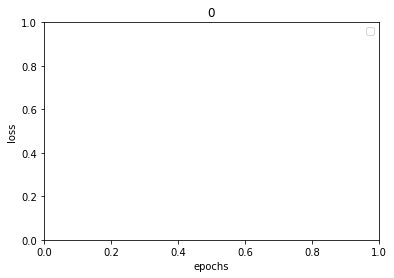

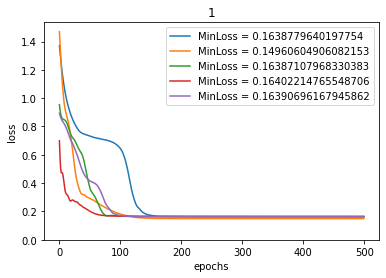

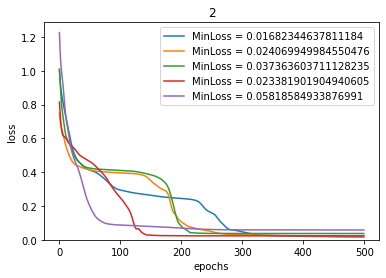

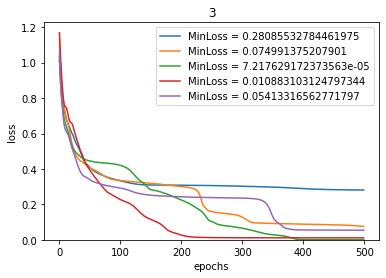

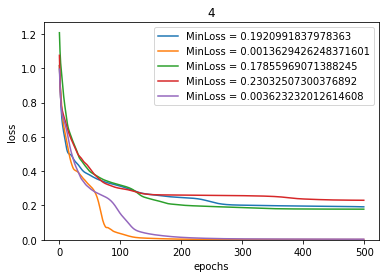

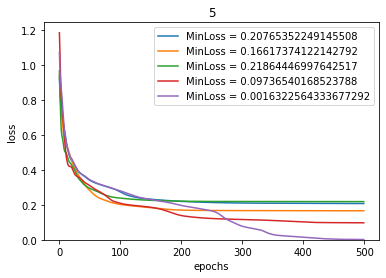

In [762]:
for it, dl in enumerate(dloss):
    plt.title("{it}".format(it=it))
    for l in dl:
        plt.plot(l, label="MinLoss = {}".format(min(l)))
    plt.ylabel("loss")
    plt.xlabel("epochs")
    plt.ylim(bottom=0)
    plt.legend()
    plt.show()



In [744]:
maxdepth = range(6,6+1)
N = 4

dddloss = []

for depth in maxdepth:
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False)
    loss_fn = tf.losses.mse

    model, quantum_model_circuit, qubits, readoutqubit = setup(N, param, extra=False, full=True, cnot=False, depth=depth)
    inputs, labels = generate_data(qubits)

    ninp = len(inputs)
    split = int(ninp*1)

    train_excitations = inputs[:split]
    train_labels = labels[:split]
    #train_labels = tf.cast(train_labels, dtype=tf.float64)

    test_excitations = inputs[split:]
    test_labels = labels[split:]



    print(model.weights)


    """batch_size = 16
    train_dataset = tf.data.Dataset.from_tensor_slices((train_excitations, train_labels))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)"""


    loss_list = []

    epochs = 1200
    train(model, train_excitations, train_labels, optimizer, loss_fn, loss_list, epochs=epochs)
    dddloss.append(loss_list)

[<tf.Variable 'parameters:0' shape=(93,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>]

Start of epoch 0
Training loss at epoch 0: 1.3187

Start of epoch 1
Training loss at epoch 1: 1.1104

Start of epoch 2
Training loss at epoch 2: 0.9913

Start of epoch 3
Training loss at epoch 3: 0.9038

Start of epoch 4
Training loss at epoch 4: 0.8130

Start of epoch 5
Training loss at epoch 5: 0.7335

Start of epoch 6
Training loss at epoch 6: 0.6791

Start of epoch 7
Training loss at epoch 7: 0.6488

Start of epoch 8
Training loss at epoch 8: 0.6311

Start of epoch 9
Training loss at epoch 9: 0.

KeyboardInterrupt: 

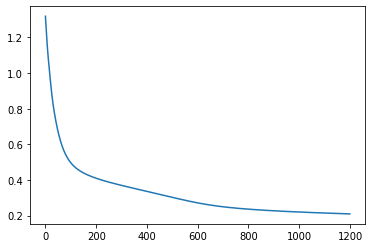

In [735]:
plt.plot(dddloss[0])

Solution to the excitation problem is found with depth of 3 full layers and:
Initial parameters:
```
array([3.142743  , 1.6211308 , 6.2127533 , 1.403728  , 0.5748421 ,
       5.8714156 , 5.158472  , 5.786588  , 1.6906012 , 3.3182492 ,
       4.858122  , 0.38375887, 0.3583126 , 5.866459  , 5.0671377 ,
       5.828251  , 0.97697425, 0.2249117 , 0.5937352 , 5.895576  ,
       5.1195526 , 4.471942  , 1.0231847 , 2.0065742 , 2.158195  ,
       1.0113435 , 0.55272895, 0.31191644, 5.727847  , 5.3882537 ,
       0.3614315 , 5.183798  , 0.8544393 , 1.5969969 , 3.1413836 ,
       5.9380727 , 0.51083434, 1.2580216 , 4.3443036 , 2.3086405 ,
       1.8087461 , 3.083661  , 0.77426183, 1.2260948 , 5.415547  ]
```
Solution parameters:
```
array([ 2.6328497 ,  1.5712917 ,  6.9862733 ,  1.9362755 ,  0.1883689 ,
        5.5261497 ,  5.3186984 ,  6.458927  ,  0.6774356 ,  3.831779  ,
        4.091107  ,  0.51859134,  0.79823154,  5.6697216 ,  4.712743  ,
        6.8606434 ,  1.5702574 ,  0.06955462,  1.2834837 ,  5.8312583 ,
        4.732993  ,  4.8076997 ,  0.890339  ,  2.2350447 ,  2.0360186 ,
        1.0049291 ,  1.9898651 , -0.15972897,  6.0006113 ,  5.6948442 ,
       -1.5710593 ,  3.9472854 ,  1.5704038 ,  1.0506094 ,  3.4380832 ,
        6.2635283 ,  1.3604025 ,  3.0867598 ,  3.2895849 ,  2.1519923 ,
        1.5507632 ,  1.5626886 ,  0.13279505,  2.5531113 ,  4.712026  ]
```

In [757]:
weightsSolve = np.array([  3.142743  , 1.6211308 , 6.2127533 , 1.403728  , 0.5748421 ,\
                           5.8714156 , 5.158472  , 5.786588  , 1.6906012 , 3.3182492 ,\
                           4.858122  , 0.38375887, 0.3583126 , 5.866459  , 5.0671377 ,\
                           5.828251  , 0.97697425, 0.2249117 , 0.5937352 , 5.895576  ,\
                           5.1195526 , 4.471942  , 1.0231847 , 2.0065742 , 2.158195  ,\
                           1.0113435 , 0.55272895, 0.31191644, 5.727847  , 5.3882537 ,\
                           0.3614315 , 5.183798  , 0.8544393 , 1.5969969 , 3.1413836 ,\
                           5.9380727 , 0.51083434, 1.2580216 , 4.3443036 , 2.3086405 ,\
                           1.8087461 , 3.083661  , 0.77426183, 1.2260948 , 5.415547  ])



In [ ]:
# BEST CONVERGENCE WAS ACHIEVED STARTING WITH:
"""
[<tf.Variable 'parameters:0' shape=(45,) dtype=float32, numpy=
array([3.142743  , 1.6211308 , 6.2127533 , 1.403728  , 0.5748421 ,
       5.8714156 , 5.158472  , 5.786588  , 1.6906012 , 3.3182492 ,
       4.858122  , 0.38375887, 0.3583126 , 5.866459  , 5.0671377 ,
       5.828251  , 0.97697425, 0.2249117 , 0.5937352 , 5.895576  ,
       5.1195526 , 4.471942  , 1.0231847 , 2.0065742 , 2.158195  ,
       1.0113435 , 0.55272895, 0.31191644, 5.727847  , 5.3882537 ,
       0.3614315 , 5.183798  , 0.8544393 , 1.5969969 , 3.1413836 ,
       5.9380727 , 0.51083434, 1.2580216 , 4.3443036 , 2.3086405 ,
       1.8087461 , 3.083661  , 0.77426183, 1.2260948 , 5.415547  ],
      dtype=float32)>]"""
# With DEPTH = 3, ADAMS OPTIMIZER

optW = np.array([3.142743  , 1.6211308 , 6.2127533 , 1.403728  , 0.5748421 ,\
       5.8714156 , 5.158472  , 5.786588  , 1.6906012 , 3.3182492 ,\
       4.858122  , 0.38375887, 0.3583126 , 5.866459  , 5.0671377 ,\
       5.828251  , 0.97697425, 0.2249117 , 0.5937352 , 5.895576  ,\
       5.1195526 , 4.471942  , 1.0231847 , 2.0065742 , 2.158195  ,\
       1.0113435 , 0.55272895, 0.31191644, 5.727847  , 5.3882537 ,\
       0.3614315 , 5.183798  , 0.8544393 , 1.5969969 , 3.1413836 ,\
       5.9380727 , 0.51083434, 1.2580216 , 4.3443036 , 2.3086405 ,\
       1.8087461 , 3.083661  , 0.77426183, 1.2260948 , 5.415547  ])

param = sympy.symbols('p:100')

depth = 3
N = 4
optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)#tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False)
loss_fn = tf.losses.mse

best_loss = []

model, quantum_model_circuit, qubits, readoutqubit = setup(N, param, extra=False, full=True, firstOne=False, cnot=False, depth=depth, random=True)
inputs, labels = generate_data(qubits)

ninp = len(inputs)
split = int(ninp*1)

train_excitations = inputs[:split]
train_labels = labels[:split]
#train_labels = tf.cast(train_labels, dtype=tf.float64)

test_excitations = inputs[split:]
test_labels = labels[split:]



#print(model.weights)
model.set_weights([optW])
#print(model.weights)

epochs = 1000
train(model, train_excitations, train_labels, optimizer, loss_fn, best_loss, epochs=epochs)




In [25]:
sol_weights = model.weights
print(sol_weights)

[<tf.Variable 'parameters:0' shape=(45,) dtype=float32, numpy=
array([ 2.6328497 ,  1.5712917 ,  6.9862733 ,  1.9362755 ,  0.1883689 ,
        5.5261497 ,  5.3186984 ,  6.458927  ,  0.6774356 ,  3.831779  ,
        4.091107  ,  0.51859134,  0.79823154,  5.6697216 ,  4.712743  ,
        6.8606434 ,  1.5702574 ,  0.06955462,  1.2834837 ,  5.8312583 ,
        4.732993  ,  4.8076997 ,  0.890339  ,  2.2350447 ,  2.0360186 ,
        1.0049291 ,  1.9898651 , -0.15972897,  6.0006113 ,  5.6948442 ,
       -1.5710593 ,  3.9472854 ,  1.5704038 ,  1.0506094 ,  3.4380832 ,
        6.2635283 ,  1.3604025 ,  3.0867598 ,  3.2895849 ,  2.1519923 ,
        1.5507632 ,  1.5626886 ,  0.13279505,  2.5531113 ,  4.712026  ],
      dtype=float32)>]


In [41]:
for w in sol_weights[0]:
    print(w/np.pi , np.round(w/np.pi*60)/60 )

tf.Tensor(0.83806205, shape=(), dtype=float32) 0.8333333333333334
tf.Tensor(0.50015765, shape=(), dtype=float32) 0.5
tf.Tensor(2.2237997, shape=(), dtype=float32) 2.216666666666667
tf.Tensor(0.61633563, shape=(), dtype=float32) 0.6166666666666667
tf.Tensor(0.059959684, shape=(), dtype=float32) 0.06666666666666667
tf.Tensor(1.7590281, shape=(), dtype=float32) 1.7666666666666666
tf.Tensor(1.6929942, shape=(), dtype=float32) 1.7
tf.Tensor(2.0559404, shape=(), dtype=float32) 2.05
tf.Tensor(0.21563444, shape=(), dtype=float32) 0.21666666666666667
tf.Tensor(1.2196931, shape=(), dtype=float32) 1.2166666666666666
tf.Tensor(1.3022398, shape=(), dtype=float32) 1.3
tf.Tensor(0.16507275, shape=(), dtype=float32) 0.16666666666666666
tf.Tensor(0.25408497, shape=(), dtype=float32) 0.25
tf.Tensor(1.8047284, shape=(), dtype=float32) 1.8
tf.Tensor(1.5001125, shape=(), dtype=float32) 1.5
tf.Tensor(2.1838105, shape=(), dtype=float32) 2.183333333333333
tf.Tensor(0.49982846, shape=(), dtype=float32) 0.5
tf.

In [46]:
print(*tuple("{:20} =? {:3}   --->   {:5}".format(x[0], train_labels[i], "yes!" if abs(train_labels[i]-x[0])<1 else "no!")  for i,x in enumerate(model.predict(train_excitations))), sep='\n')

  0.9967101812362671 =?   1   --->   yes! 
  0.9986864924430847 =?   1   --->   yes! 
  0.9977095723152161 =?   1   --->   yes! 
  0.9989843964576721 =?   1   --->   yes! 
  0.9978319406509399 =?   1   --->   yes! 
  0.9967343807220459 =?   1   --->   yes! 
  0.9980698823928833 =?   1   --->   yes! 
 -0.9972653388977051 =?  -1   --->   yes! 
  0.9981792569160461 =?   1   --->   yes! 
  0.9985648989677429 =?   1   --->   yes! 
  0.9990745782852173 =?   1   --->   yes! 
 -0.9978370666503906 =?  -1   --->   yes! 
  0.9982478618621826 =?   1   --->   yes! 
 -0.9987651109695435 =?  -1   --->   yes! 
 -0.9970437288284302 =?  -1   --->   yes! 
 -0.9956232309341431 =?  -1   --->   yes! 
